In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
</style>

In [3]:
import asyncio
from itertools import cycle, islice
from lib import models
from lib.grpo import GRPO
from lib.pack import packed_tensors_from_tokenized_results, plot_packed_tensors
from lib.recipe import ComponentConfig, TuneRecipeConfig
from lib.tasks import ChatCompletionParams, get_task_results
from lib.temporal_clue import get_temporal_clue_tasks
from lib.tokenize import TaskResultTokenizer
from lib.tune import clear_iteration_dirs, get_iteration, get_last_iteration_dir, last_tune_log, tune, Verbosity
from lib.utils import rsync_dir
from lib.vllm import start_vllm, kill_vllm_workers
import polars as pl
import random
import torch
from transformers import AutoTokenizer
import wandb

run_name = "025"
run = wandb.init(
    project="grpo-tests",
    name=run_name,
    id=run_name,
    resume="allow",
    config={"task": "temporal-clue"},
)

tasks = list(get_temporal_clue_tasks())
val_tasks = tasks[:64]
test_tasks = tasks[64:128]
train_tasks = tasks[128:]
random.seed(42)
random.shuffle(train_tasks)
len(val_tasks), len(test_tasks), len(train_tasks)

wandb: Currently logged in as: bradhilton to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


(64, 64, 2860)

In [4]:
# GRPO params
wandb.config["clip_epsilon"] = clip_epsilon = 0.2
wandb.config["entropy_coef"] = entropy_coef = 0.0
wandb.config["kl_coef"] = kl_coef = 0.0
wandb.config["tanh"] = tanh = False

expected_tokens = 300  # Expected completion tokens per task sample
wandb.config["lr"] = lr = 3e-6
wandb.config["betas"] = betas = (0.9, 0.999)  # (0.9, 0.99)
wandb.config["weight_decay"] = weight_decay = 0.01  # 0.1
model = models.theta_8b()
wandb.config["model"] = model.base_model
num_iterations = 1_000
output_dir = f"./models/{run_name}"
wandb.config["samples_per_task"] = samples_per_task = 50  # 64
wandb.config["seq_len"] = seq_len = 16384
wandb.config["stride"] = stride = 32  # 8
wandb.config["tasks_per_iter"] = tasks_per_iter = 64  # 8
sync_dir = output_dir  # symlink_shm(output_dir) or output_dir
tokenizer = AutoTokenizer.from_pretrained(model.base_model)
verbosity: Verbosity = 2

$ vllm serve /home/ubuntu/sky_workdir/experiments/models/025/0002 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/025/0002 --port=8000 --api-key=default
INFO 02-21 02:23:00 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 02:23:01 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 02:23:01 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/025/0002', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None, chat_template_content_format='auto', response_role

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:01<00:03,  1.29s/it]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:06<00:07,  3.55s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:09<00:03,  3.27s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:12<00:00,  3.10s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:12<00:00,  3.05s/it]



INFO 02-21 02:23:28 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-21 02:23:29 worker.py:267] Memory profiling takes 0.85 seconds
INFO 02-21 02:23:29 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-21 02:23:29 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.24GiB.
INFO 02-21 02:23:29 executor_base.py:110] # CUDA blocks: 14140, # CPU blocks: 20480
INFO 02-21 02:23:29 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.62x
INFO 02-21 02:24:12 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 44.75 seconds
INFO 02-21 02:24:13 api_server.py:756] Using supplied chat template:
INFO 02-21 02:24:13 api_server.py:756] None
INFO 02-21 02:24:13 launcher.py:21] Available routes are:
INFO 02-21 02:24:13 launcher.py:29] Route: /

INFO:     Started server process [13280]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 02:24:20 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO 02-21 02:24:21 metrics.py:455] Avg prompt throughput: 1.3 tokens/s, Avg generation throughput: 0.1 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 02-21 02:24:21 metrics.py:471] Prefix cache hit rate: GPU: 0.00%, CPU: 0.00%
INFO:     127.0.0.1:36440 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [04:44<00:00, 11.84s/it, completion_tokens=264, prompt_tokens=1.17e+3, reward=0.295, token_logprobs=843217]
Deleted iteration directory ./models/025/0001


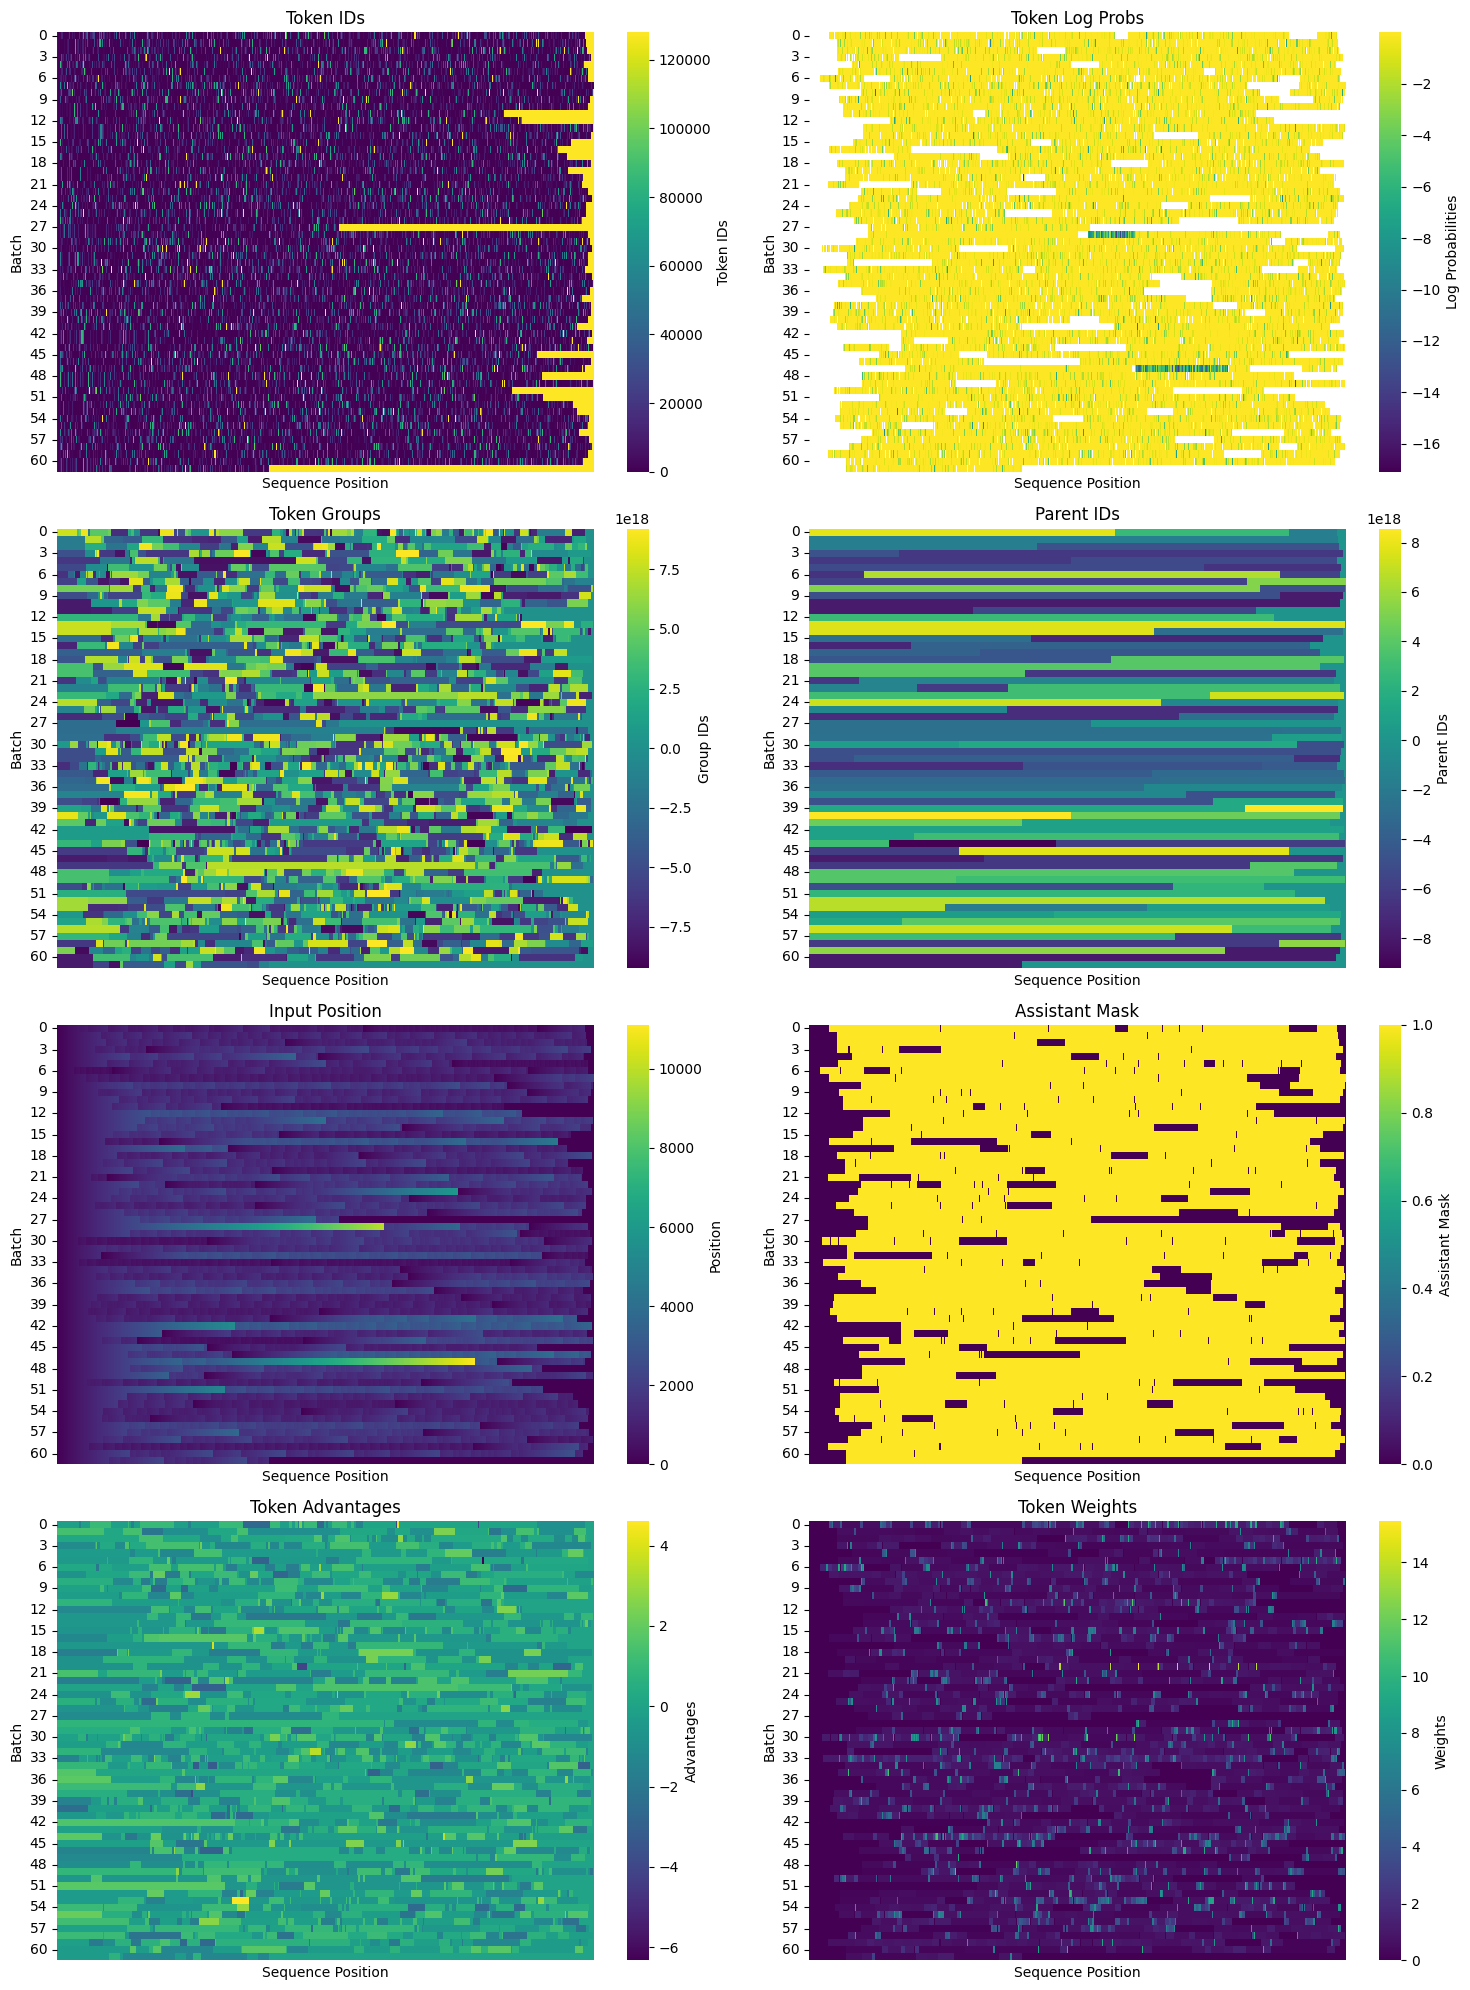

rsyncing /home/ubuntu/sky_workdir/experiments/models/025 to gs://atreides/openpipe/models/025
$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/025/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/025/0002
  checkpoint_files:
  - hf_model_0004.pt
  - hf_model_0003.pt
  - hf_model_0002.pt
  - hf_model_0001.pt
  model_type: LLAMA3
  output_dir: ./models/025
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/025/tensors
  num_sequences: 62
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tanh: false
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.training.metric

Writing logs to models/025/logs/log_1740104980.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 21.27 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|31|Loss: -0.0127: 100%|██████████| 31/31 [13:07<00:00, 25.08s/it, entropy=0.267, kl_div=nan, loss=-0.0127, policy=-0.0127]  INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 10.70 secs
INFO:torchtune.utils._logging:Model checkpoint of size 4.98 GB sa

Saved iteration #3 model files to ./models/025/0003
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/025/0003 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/025/0003 --port=8000 --api-key=default
INFO 02-21 02:43:57 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 02:43:58 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 02:43:58 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/025/0003', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:01<00:03,  1.28s/it]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:06<00:06,  3.47s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:09<00:03,  3.23s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:12<00:00,  3.08s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:12<00:00,  3.02s/it]



INFO 02-21 02:44:27 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-21 02:44:28 worker.py:267] Memory profiling takes 0.84 seconds
INFO 02-21 02:44:28 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-21 02:44:28 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.24GiB.
INFO 02-21 02:44:28 executor_base.py:110] # CUDA blocks: 14140, # CPU blocks: 20480
INFO 02-21 02:44:28 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.62x
INFO 02-21 02:45:15 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 47.53 seconds
INFO 02-21 02:45:16 api_server.py:756] Using supplied chat template:
INFO 02-21 02:45:16 api_server.py:756] None
INFO 02-21 02:45:16 launcher.py:21] Available routes are:
INFO 02-21 02:45:16 launcher.py:29] Route: /

INFO:     Started server process [15643]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 02:45:17 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:45108 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [04:03<00:00,  8.67s/it, completion_tokens=214, prompt_tokens=1.14e+3, reward=0.306, token_logprobs=685817]


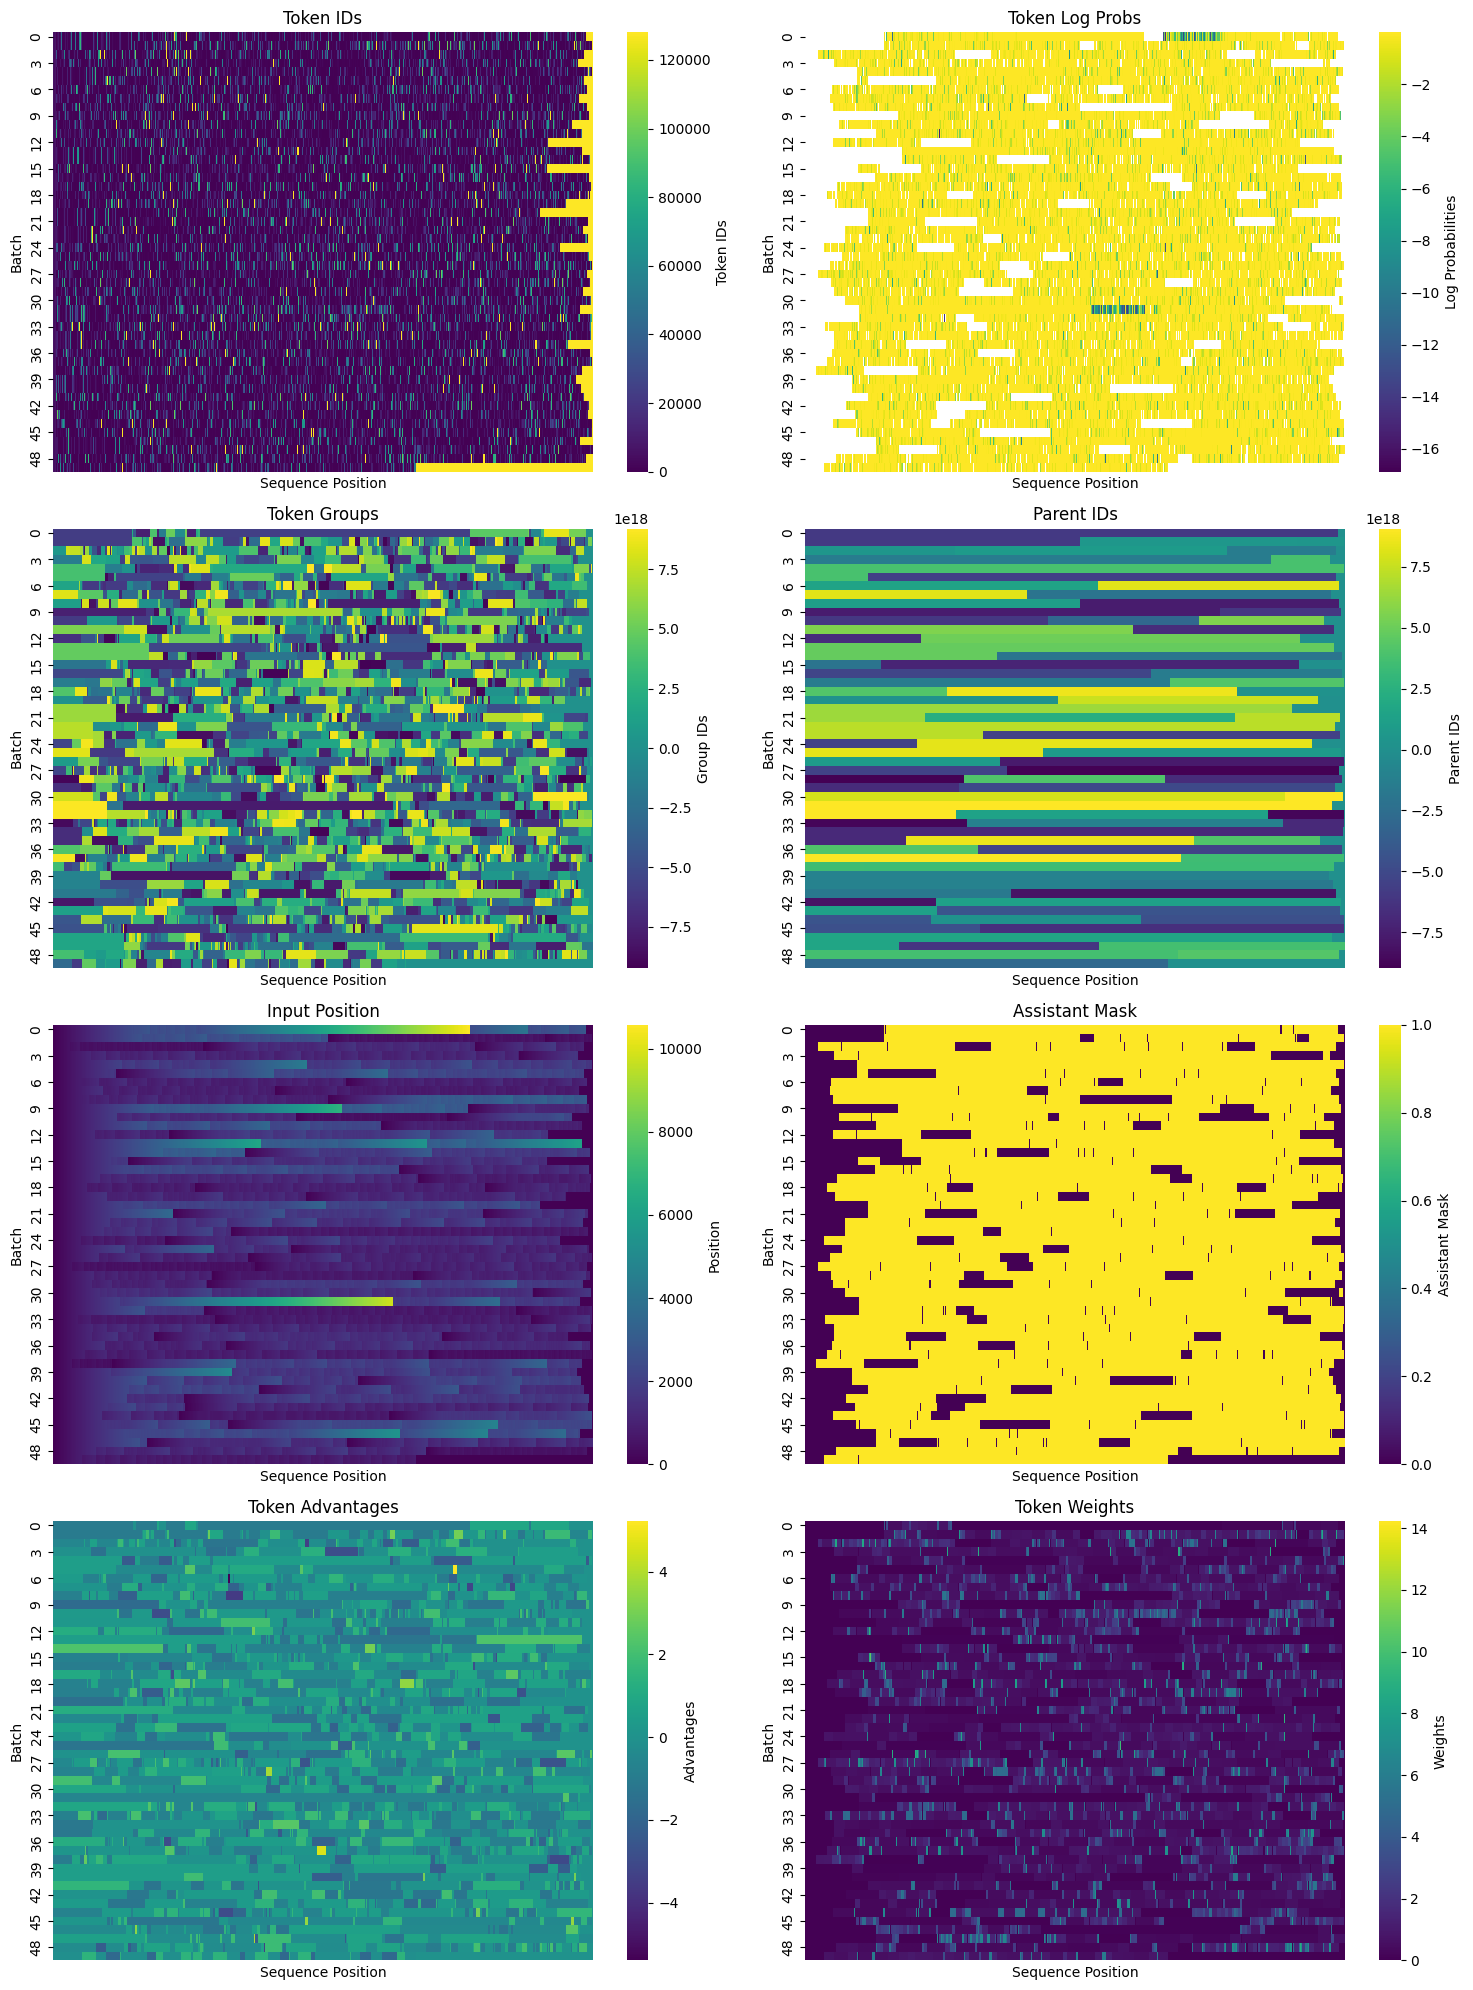

rsyncing /home/ubuntu/sky_workdir/experiments/models/025 to gs://atreides/openpipe/models/025
$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/025/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/025/0003
  checkpoint_files:
  - hf_model_0004.pt
  - hf_model_0003.pt
  - hf_model_0002.pt
  - hf_model_0001.pt
  model_type: LLAMA3
  output_dir: ./models/025
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/025/tensors
  num_sequences: 50
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tanh: false
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.training.metric

Writing logs to models/025/logs/log_1740106192.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 37.36 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|25|Loss: 0.0336: 100%|██████████| 25/25 [10:43<00:00, 25.04s/it, entropy=0.274, kl_div=nan, loss=0.0336, policy=0.0336]    INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 10.61 secs
INFO:torchtune.utils._logging:Model checkpoint of size 4.98 GB sav

Saved iteration #4 model files to ./models/025/0004
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/025/0004 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/025/0004 --port=8000 --api-key=default
INFO 02-21 03:02:01 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 03:02:02 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 03:02:02 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/025/0004', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:01<00:03,  1.28s/it]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:06<00:07,  3.56s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:09<00:03,  3.27s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:12<00:00,  3.11s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:12<00:00,  3.06s/it]



INFO 02-21 03:02:32 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-21 03:02:33 worker.py:267] Memory profiling takes 0.90 seconds
INFO 02-21 03:02:33 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-21 03:02:33 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.24GiB.
INFO 02-21 03:02:34 executor_base.py:110] # CUDA blocks: 14140, # CPU blocks: 20480
INFO 02-21 03:02:34 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.62x
INFO 02-21 03:03:20 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 48.02 seconds
INFO 02-21 03:03:22 api_server.py:756] Using supplied chat template:
INFO 02-21 03:03:22 api_server.py:756] None
INFO 02-21 03:03:22 launcher.py:21] Available routes are:
INFO 02-21 03:03:22 launcher.py:29] Route: /

INFO:     Started server process [17740]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 03:03:24 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:58354 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [04:53<00:00,  1.29s/it, completion_tokens=191, prompt_tokens=1.15e+3, reward=0.345, token_logprobs=611715]
Deleted iteration directory ./models/025/0003


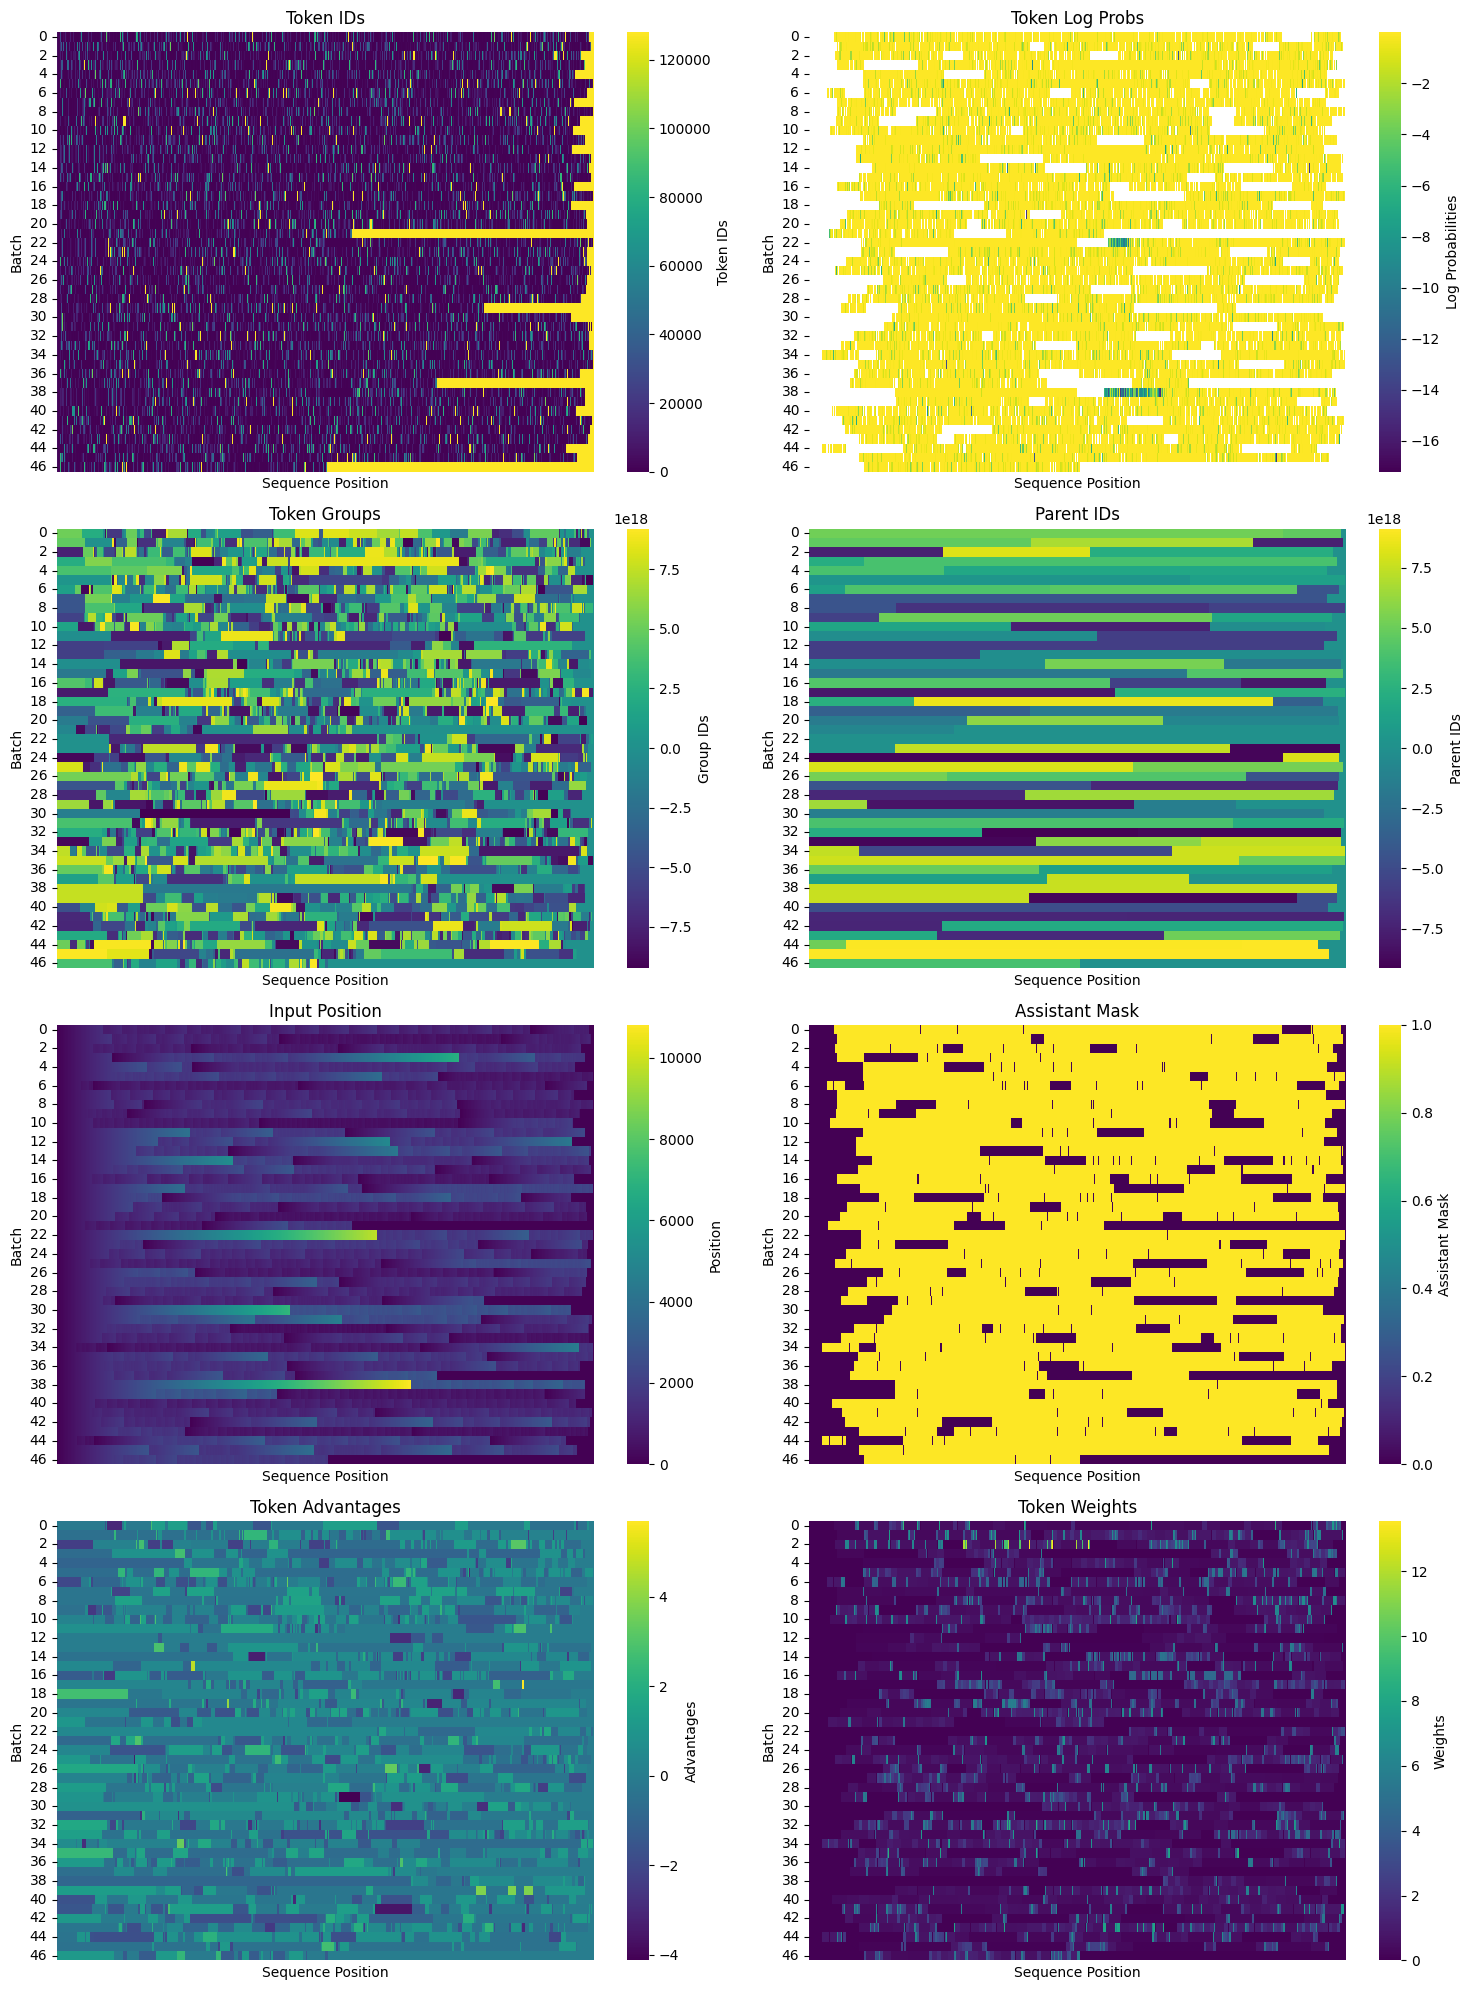

rsyncing /home/ubuntu/sky_workdir/experiments/models/025 to gs://atreides/openpipe/models/025
$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/025/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/025/0004
  checkpoint_files:
  - hf_model_0004.pt
  - hf_model_0003.pt
  - hf_model_0002.pt
  - hf_model_0001.pt
  model_type: LLAMA3
  output_dir: ./models/025
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/025/tensors
  num_sequences: 47
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tanh: false
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.training.metric

Writing logs to models/025/logs/log_1740107326.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 24.91 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|23|Loss: 0.0741: 100%|██████████| 23/23 [09:56<00:00, 25.01s/it, entropy=0.115, kl_div=nan, loss=0.0741, policy=0.0741]     INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 10.67 secs
INFO:torchtune.utils._logging:Model checkpoint of size 4.98 GB sa

Saved iteration #5 model files to ./models/025/0005
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/025/0005 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/025/0005 --port=8000 --api-key=default
INFO 02-21 03:19:55 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 03:19:57 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 03:19:57 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/025/0005', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:01<00:03,  1.27s/it]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:05<00:06,  3.17s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:08<00:03,  3.06s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:11<00:00,  2.99s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:11<00:00,  2.89s/it]



INFO 02-21 03:20:22 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-21 03:20:23 worker.py:267] Memory profiling takes 0.85 seconds
INFO 02-21 03:20:23 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-21 03:20:23 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.24GiB.
INFO 02-21 03:20:24 executor_base.py:110] # CUDA blocks: 14140, # CPU blocks: 20480
INFO 02-21 03:20:24 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.62x
INFO 02-21 03:21:12 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 49.16 seconds
INFO 02-21 03:21:13 api_server.py:756] Using supplied chat template:
INFO 02-21 03:21:13 api_server.py:756] None
INFO 02-21 03:21:13 launcher.py:21] Available routes are:
INFO 02-21 03:21:13 launcher.py:29] Route: /

INFO:     Started server process [19823]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 03:21:14 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:34118 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [05:11<00:00,  1.16s/it, completion_tokens=188, prompt_tokens=1.3e+3, reward=0.346, token_logprobs=601973]
Deleted iteration directory ./models/025/0002


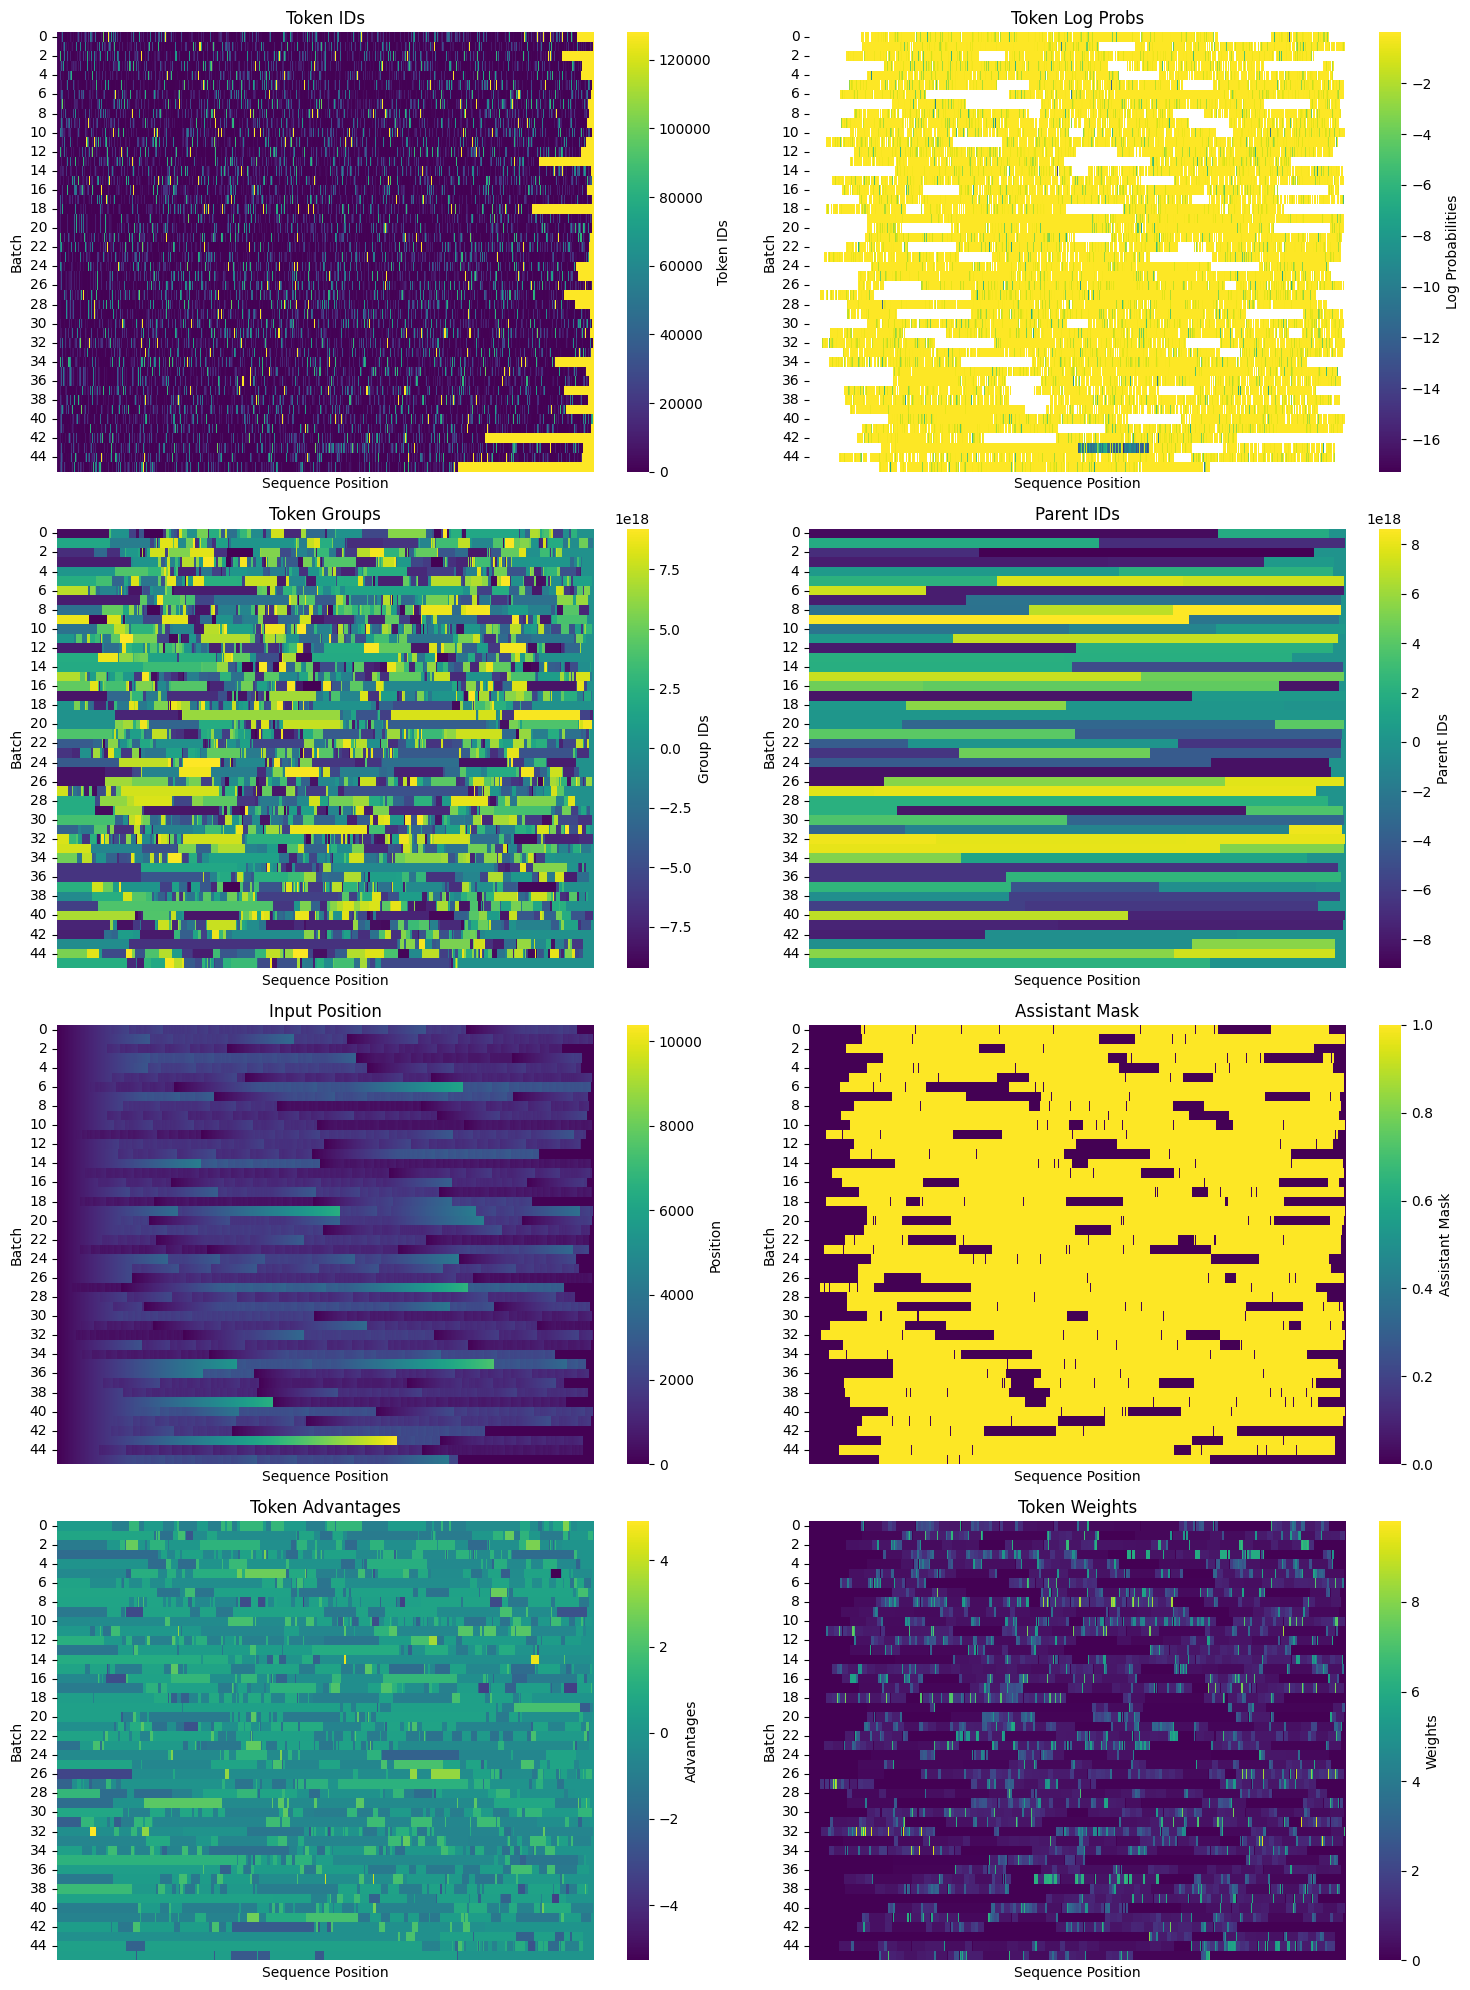

rsyncing /home/ubuntu/sky_workdir/experiments/models/025 to gs://atreides/openpipe/models/025
$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/025/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/025/0005
  checkpoint_files:
  - hf_model_0004.pt
  - hf_model_0003.pt
  - hf_model_0002.pt
  - hf_model_0001.pt
  model_type: LLAMA3
  output_dir: ./models/025
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/025/tensors
  num_sequences: 46
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tanh: false
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.training.metric

Writing logs to models/025/logs/log_1740108418.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 33.46 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|23|Loss: -0.0207: 100%|██████████| 23/23 [09:59<00:00, 25.10s/it, entropy=0.202, kl_div=nan, loss=-0.0207, policy=-0.0207]  INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 10.63 secs
INFO:torchtune.utils._logging:Model checkpoint of size 4.98 GB sa

Saved iteration #6 model files to ./models/025/0006
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/025/0006 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/025/0006 --port=8000 --api-key=default
INFO 02-21 03:38:19 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 03:38:20 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 03:38:20 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/025/0006', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:01<00:03,  1.27s/it]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:05<00:06,  3.07s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:08<00:03,  3.01s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:11<00:00,  2.95s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:11<00:00,  2.85s/it]



INFO 02-21 03:38:50 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-21 03:38:51 worker.py:267] Memory profiling takes 0.89 seconds
INFO 02-21 03:38:51 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-21 03:38:51 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.24GiB.
INFO 02-21 03:38:51 executor_base.py:110] # CUDA blocks: 14140, # CPU blocks: 20480
INFO 02-21 03:38:51 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.62x
INFO 02-21 03:39:39 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 49.52 seconds
INFO 02-21 03:39:40 api_server.py:756] Using supplied chat template:
INFO 02-21 03:39:40 api_server.py:756] None
INFO 02-21 03:39:40 launcher.py:21] Available routes are:
INFO 02-21 03:39:40 launcher.py:29] Route: /

INFO:     Started server process [21976]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 03:39:41 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:53790 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

In [ ]:
model_name = get_last_iteration_dir(output_dir) or model.base_model
for i in range(get_iteration(output_dir), num_iterations):
    vllm = await start_vllm(
        model_name,
        max_concurrent_requests=1024,
        env={"VLLM_ALLOW_LONG_MAX_MODEL_LEN": "1"},
        named_arguments=dict(
            block_size=32,
            disable_log_requests=True,
            enable_prefix_caching=True,
            enforce_eager=True,
            gpu_memory_utilization=0.95,
            max_model_len=16384,
            max_num_seqs=1024,
            max_num_batched_tokens=16384,
            num_scheduler_steps=8,
            preemption_mode="swap",
            return_tokens_as_token_ids=True,
            swap_space=80,
            tensor_parallel_size=torch.cuda.device_count(),
        ),
        timeout=180 + 15 * torch.cuda.device_count(),
        verbosity=verbosity,
    )
    semaphore = asyncio.Semaphore(
        int(1.33 * vllm.max_concurrent_tokens / expected_tokens)
    )
    offset = i * stride
    val_results, train_results = await asyncio.gather(
        get_task_results(
            tasks=val_tasks,
            client=vllm.client,
            model=vllm.model,
            cache=False,
            log_results=8,
            params=ChatCompletionParams(
                stream_options={
                    "include_usage": True,
                },
                max_completion_tokens=8192,
            ),
            pbar_desc="val",
            semaphore=semaphore,
        ),
        get_task_results(
            tasks=list(islice(cycle(train_tasks), offset, offset + tasks_per_iter)),
            client=vllm.client,
            model=vllm.model,
            cache=False,
            log_results=False,
            n=samples_per_task,
            params=ChatCompletionParams(
                stream_options={
                    "include_usage": True,
                },
                max_completion_tokens=8192,
            ),
            pbar_desc="train",
            semaphore=semaphore,
            transform=TaskResultTokenizer(tokenizer),
        ),
    )
    vllm.process.terminate()
    kill_vllm_workers()
    val_stats = val_results.stats
    assert val_stats.grades > 0
    assert val_stats.usages > 0
    wandb_data = {
        "iteration": i,
        "exceptions": val_stats.exceptions + train_results.stats.exceptions,
        "reward": val_stats.total_reward / val_stats.grades,
        "tokens": round(val_stats.completion_tokens / val_stats.usages),
    }
    try:
        wandb_data.update(
            pl.DataFrame(last_tune_log(output_dir)).drop("step").mean().to_dicts()[0]
        )
    except Exception:
        pass
    wandb.log(wandb_data)
    expected_tokens = wandb_data["tokens"]
    try:
        best_iteration = (
            wandb.Api()
            .run(f"{run.entity}/{run.project}/{run.id}")
            .history()
            .sort_values(by="reward")["iteration"]
            .iloc[-1]
        )
        clear_iteration_dirs(output_dir, [best_iteration, i])
    except Exception:
        pass
    # see ./logs/rsync.log for output
    asyncio.create_task(rsync_dir(sync_dir, "gs://atreides/openpipe/"))
    tokenized_results = [
        result
        for results in train_results
        for result in results
        if result.advantage != 0
    ]
    packed_tensors = packed_tensors_from_tokenized_results(
        tokenized_results,
        seq_len=seq_len,
        pad_token_id=tokenizer.pad_token_id,  # type: ignore
    )
    if verbosity == 2:
        plot_packed_tensors(packed_tensors)
    else:
        print(f"Packed tensors into {packed_tensors["tokens"].size()} shape")
    optimizer_config = ComponentConfig(
        model.tune_optimizer,
        lr=lr,
        betas=betas,
        weight_decay=weight_decay,
    )
    if model.tune_optimizer == "torch.optim.AdamW":
        optimizer_config.fused = True
    model_name = await tune(
        base_model=model.base_model,
        output_dir=output_dir, 
        packed_tensors=packed_tensors,
        model=model.tune_model,
        model_type=model.tune_model_type,
        config=TuneRecipeConfig(
            optimizer=optimizer_config,
            loss=ComponentConfig(
                GRPO,
                clip_epsilon=clip_epsilon,
                entropy_coef=entropy_coef,
                kl_coef=kl_coef,
                tanh=tanh,
            ),
            shuffle=True,
            batch_size=model.tune_max_batch_tokens // seq_len,
            fsdp_cpu_offload=model.tune_fsdp_cpu_offload,
            enable_activation_checkpointing=True,
            enable_activation_offloading=True,
            custom_sharded_layers=["tok_embeddings", "output"],
            num_output_chunks=2,
        ),
        verbosity=verbosity,
    )
wandb.finish()

$ vllm serve /home/ubuntu/sky_workdir/experiments/models/025/0006 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/025/0006 --port=8000 --api-key=default
INFO 02-21 04:04:59 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 04:05:01 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 04:05:01 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/025/0006', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None, chat_template_content_format='auto', response_role

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:01<00:03,  1.25s/it]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:05<00:05,  2.82s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:08<00:02,  2.86s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:10<00:00,  2.86s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:10<00:00,  2.73s/it]



INFO 02-21 04:05:23 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-21 04:05:24 worker.py:267] Memory profiling takes 0.89 seconds
INFO 02-21 04:05:24 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-21 04:05:24 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.24GiB.
INFO 02-21 04:05:24 executor_base.py:110] # CUDA blocks: 14140, # CPU blocks: 20480
INFO 02-21 04:05:24 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.62x
INFO 02-21 04:06:14 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 51.54 seconds
INFO 02-21 04:06:15 api_server.py:756] Using supplied chat template:
INFO 02-21 04:06:15 api_server.py:756] None
INFO 02-21 04:06:15 launcher.py:21] Available routes are:
INFO 02-21 04:06:15 launcher.py:29] Route: /

INFO:     Started server process [22711]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 04:06:20 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:38004 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [04:28<00:00,  6.81s/it, completion_tokens=205, prompt_tokens=1287, reward=0.313, token_logprobs=656372]
Deleted iteration directory ./models/025/0004


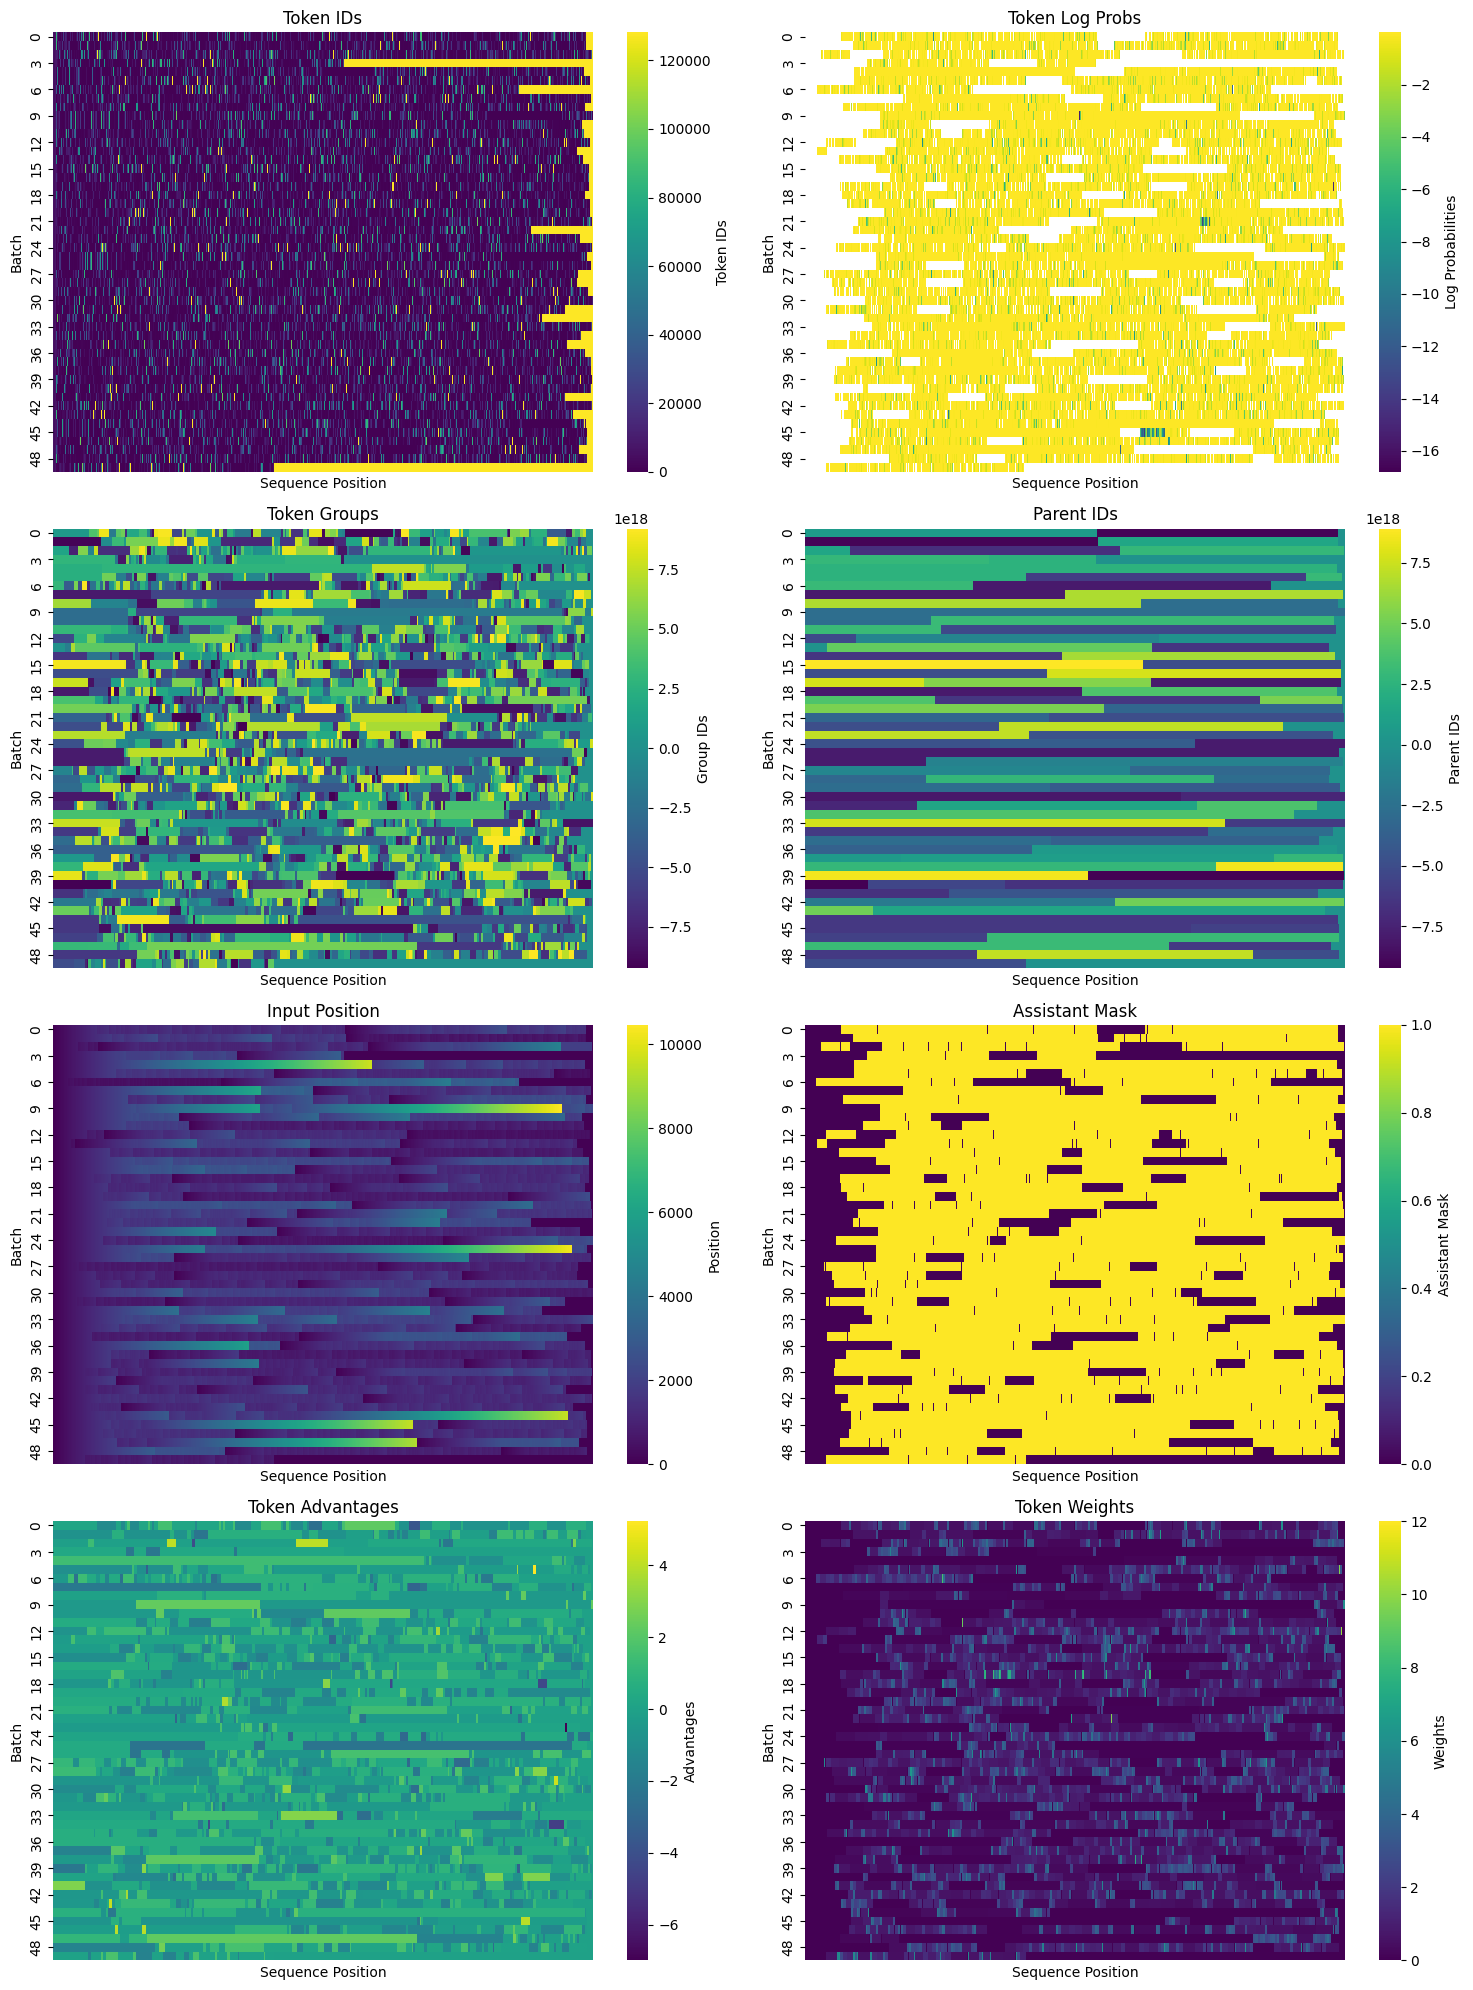

rsyncing /home/ubuntu/sky_workdir/experiments/models/025 to gs://atreides/openpipe/models/025
$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/025/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/025/0006
  checkpoint_files:
  - hf_model_0004.pt
  - hf_model_0003.pt
  - hf_model_0002.pt
  - hf_model_0001.pt
  model_type: LLAMA3
  output_dir: ./models/025
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/025/tensors
  num_sequences: 50
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tanh: false
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.training.metric

Writing logs to models/025/logs/log_1740111083.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 43.91 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|25|Loss: -0.0461: 100%|██████████| 25/25 [10:46<00:00, 25.11s/it, entropy=0.163, kl_div=nan, loss=-0.0461, policy=-0.0461]  INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 10.61 secs
INFO:torchtune.utils._logging:Model checkpoint of size 4.98 GB sa

Saved iteration #7 model files to ./models/025/0007
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/025/0007 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/025/0007 --port=8000 --api-key=default
INFO 02-21 04:23:41 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 04:23:42 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 04:23:42 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/025/0007', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:01<00:03,  1.26s/it]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:06<00:07,  3.54s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:09<00:03,  3.34s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:12<00:00,  3.15s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:12<00:00,  3.09s/it]



INFO 02-21 04:24:13 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-21 04:24:14 worker.py:267] Memory profiling takes 0.85 seconds
INFO 02-21 04:24:14 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-21 04:24:14 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.24GiB.
INFO 02-21 04:24:14 executor_base.py:110] # CUDA blocks: 14140, # CPU blocks: 20480
INFO 02-21 04:24:14 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.62x
INFO 02-21 04:25:00 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 47.01 seconds
INFO 02-21 04:25:00 api_server.py:756] Using supplied chat template:
INFO 02-21 04:25:00 api_server.py:756] None
INFO 02-21 04:25:00 launcher.py:21] Available routes are:
INFO 02-21 04:25:00 launcher.py:29] Route: /

INFO:     Started server process [24778]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 04:25:01 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:35884 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

In [ ]:
model_name = get_last_iteration_dir(output_dir) or model.base_model
for i in range(get_iteration(output_dir), num_iterations):
    vllm = await start_vllm(
        model_name,
        max_concurrent_requests=1024,
        env={"VLLM_ALLOW_LONG_MAX_MODEL_LEN": "1"},
        named_arguments=dict(
            block_size=32,
            disable_log_requests=True,
            enable_prefix_caching=True,
            enforce_eager=True,
            gpu_memory_utilization=0.95,
            max_model_len=16384,
            max_num_seqs=1024,
            max_num_batched_tokens=16384,
            num_scheduler_steps=8,
            preemption_mode="swap",
            return_tokens_as_token_ids=True,
            swap_space=80,
            tensor_parallel_size=torch.cuda.device_count(),
        ),
        timeout=180 + 15 * torch.cuda.device_count(),
        verbosity=verbosity,
    )
    semaphore = asyncio.Semaphore(
        int(1.33 * vllm.max_concurrent_tokens / expected_tokens)
    )
    offset = i * stride
    val_results, train_results = await asyncio.gather(
        get_task_results(
            tasks=val_tasks,
            client=vllm.client,
            model=vllm.model,
            cache=False,
            log_results=8,
            params=ChatCompletionParams(
                stream_options={
                    "include_usage": True,
                },
                max_completion_tokens=8192,
            ),
            pbar_desc="val",
            semaphore=semaphore,
        ),
        get_task_results(
            tasks=list(islice(cycle(train_tasks), offset, offset + tasks_per_iter)),
            client=vllm.client,
            model=vllm.model,
            cache=False,
            log_results=False,
            n=samples_per_task,
            params=ChatCompletionParams(
                stream_options={
                    "include_usage": True,
                },
                max_completion_tokens=8192,
            ),
            pbar_desc="train",
            semaphore=semaphore,
            transform=TaskResultTokenizer(tokenizer),
        ),
    )
    vllm.process.terminate()
    kill_vllm_workers()
    val_stats = val_results.stats
    assert val_stats.grades > 0
    assert val_stats.usages > 0
    wandb_data = {
        "iteration": i,
        "exceptions": val_stats.exceptions + train_results.stats.exceptions,
        "reward": val_stats.total_reward / val_stats.grades,
        "tokens": round(val_stats.completion_tokens / val_stats.usages),
    }
    try:
        wandb_data.update(
            pl.DataFrame(last_tune_log(output_dir)).drop("step").mean().to_dicts()[0]
        )
    except Exception:
        pass
    wandb.log(wandb_data)
    expected_tokens = wandb_data["tokens"]
    try:
        best_iteration = (
            wandb.Api()
            .run(f"{run.entity}/{run.project}/{run.id}")
            .history()
            .sort_values(by="reward")["iteration"]
            .iloc[-1]
        )
        clear_iteration_dirs(output_dir, [best_iteration, i])
    except Exception:
        pass
    # see ./logs/rsync.log for output
    asyncio.create_task(rsync_dir(sync_dir, "gs://atreides/openpipe/"))
    tokenized_results = [
        result
        for results in train_results
        for result in results
        if result.advantage != 0
    ]
    packed_tensors = packed_tensors_from_tokenized_results(
        tokenized_results,
        seq_len=seq_len,
        pad_token_id=tokenizer.pad_token_id,  # type: ignore
    )
    if verbosity == 2:
        plot_packed_tensors(packed_tensors)
    else:
        print(f"Packed tensors into {packed_tensors["tokens"].size()} shape")
    optimizer_config = ComponentConfig(
        model.tune_optimizer,
        lr=lr,
        betas=betas,
        weight_decay=weight_decay,
    )
    if model.tune_optimizer == "torch.optim.AdamW":
        optimizer_config.fused = True
    model_name = await tune(
        base_model=model.base_model,
        output_dir=output_dir, 
        packed_tensors=packed_tensors,
        model=model.tune_model,
        model_type=model.tune_model_type,
        config=TuneRecipeConfig(
            optimizer=optimizer_config,
            loss=ComponentConfig(
                GRPO,
                clip_epsilon=clip_epsilon,
                entropy_coef=entropy_coef,
                kl_coef=kl_coef,
                tanh=tanh,
            ),
            shuffle=True,
            batch_size=model.tune_max_batch_tokens // seq_len,
            fsdp_cpu_offload=model.tune_fsdp_cpu_offload,
            enable_activation_checkpointing=True,
            enable_activation_offloading=True,
            custom_sharded_layers=["tok_embeddings", "output"],
            num_output_chunks=2,
        ),
        verbosity=verbosity,
    )
wandb.finish()

$ vllm serve /home/ubuntu/sky_workdir/experiments/models/025/0007 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/025/0007 --port=8000 --api-key=default
INFO 02-21 04:53:29 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 04:53:30 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 04:53:30 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/025/0007', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None, chat_template_content_format='auto', response_role

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:01<00:03,  1.26s/it]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:05<00:05,  2.85s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:08<00:02,  2.89s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:10<00:00,  2.87s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:10<00:00,  2.75s/it]



INFO 02-21 04:53:58 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-21 04:53:59 worker.py:267] Memory profiling takes 0.84 seconds
INFO 02-21 04:53:59 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-21 04:53:59 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.24GiB.
INFO 02-21 04:53:59 executor_base.py:110] # CUDA blocks: 14140, # CPU blocks: 20480
INFO 02-21 04:53:59 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.62x
INFO 02-21 04:54:46 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 48.63 seconds
INFO 02-21 04:54:47 api_server.py:756] Using supplied chat template:
INFO 02-21 04:54:47 api_server.py:756] None
INFO 02-21 04:54:47 launcher.py:21] Available routes are:
INFO 02-21 04:54:47 launcher.py:29] Route: /

INFO:     Started server process [27730]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 04:54:49 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:55976 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [04:14<00:00,  4.24s/it, completion_tokens=193, prompt_tokens=1171, reward=0.301, token_logprobs=618869]
Deleted iteration directory ./models/025/0006


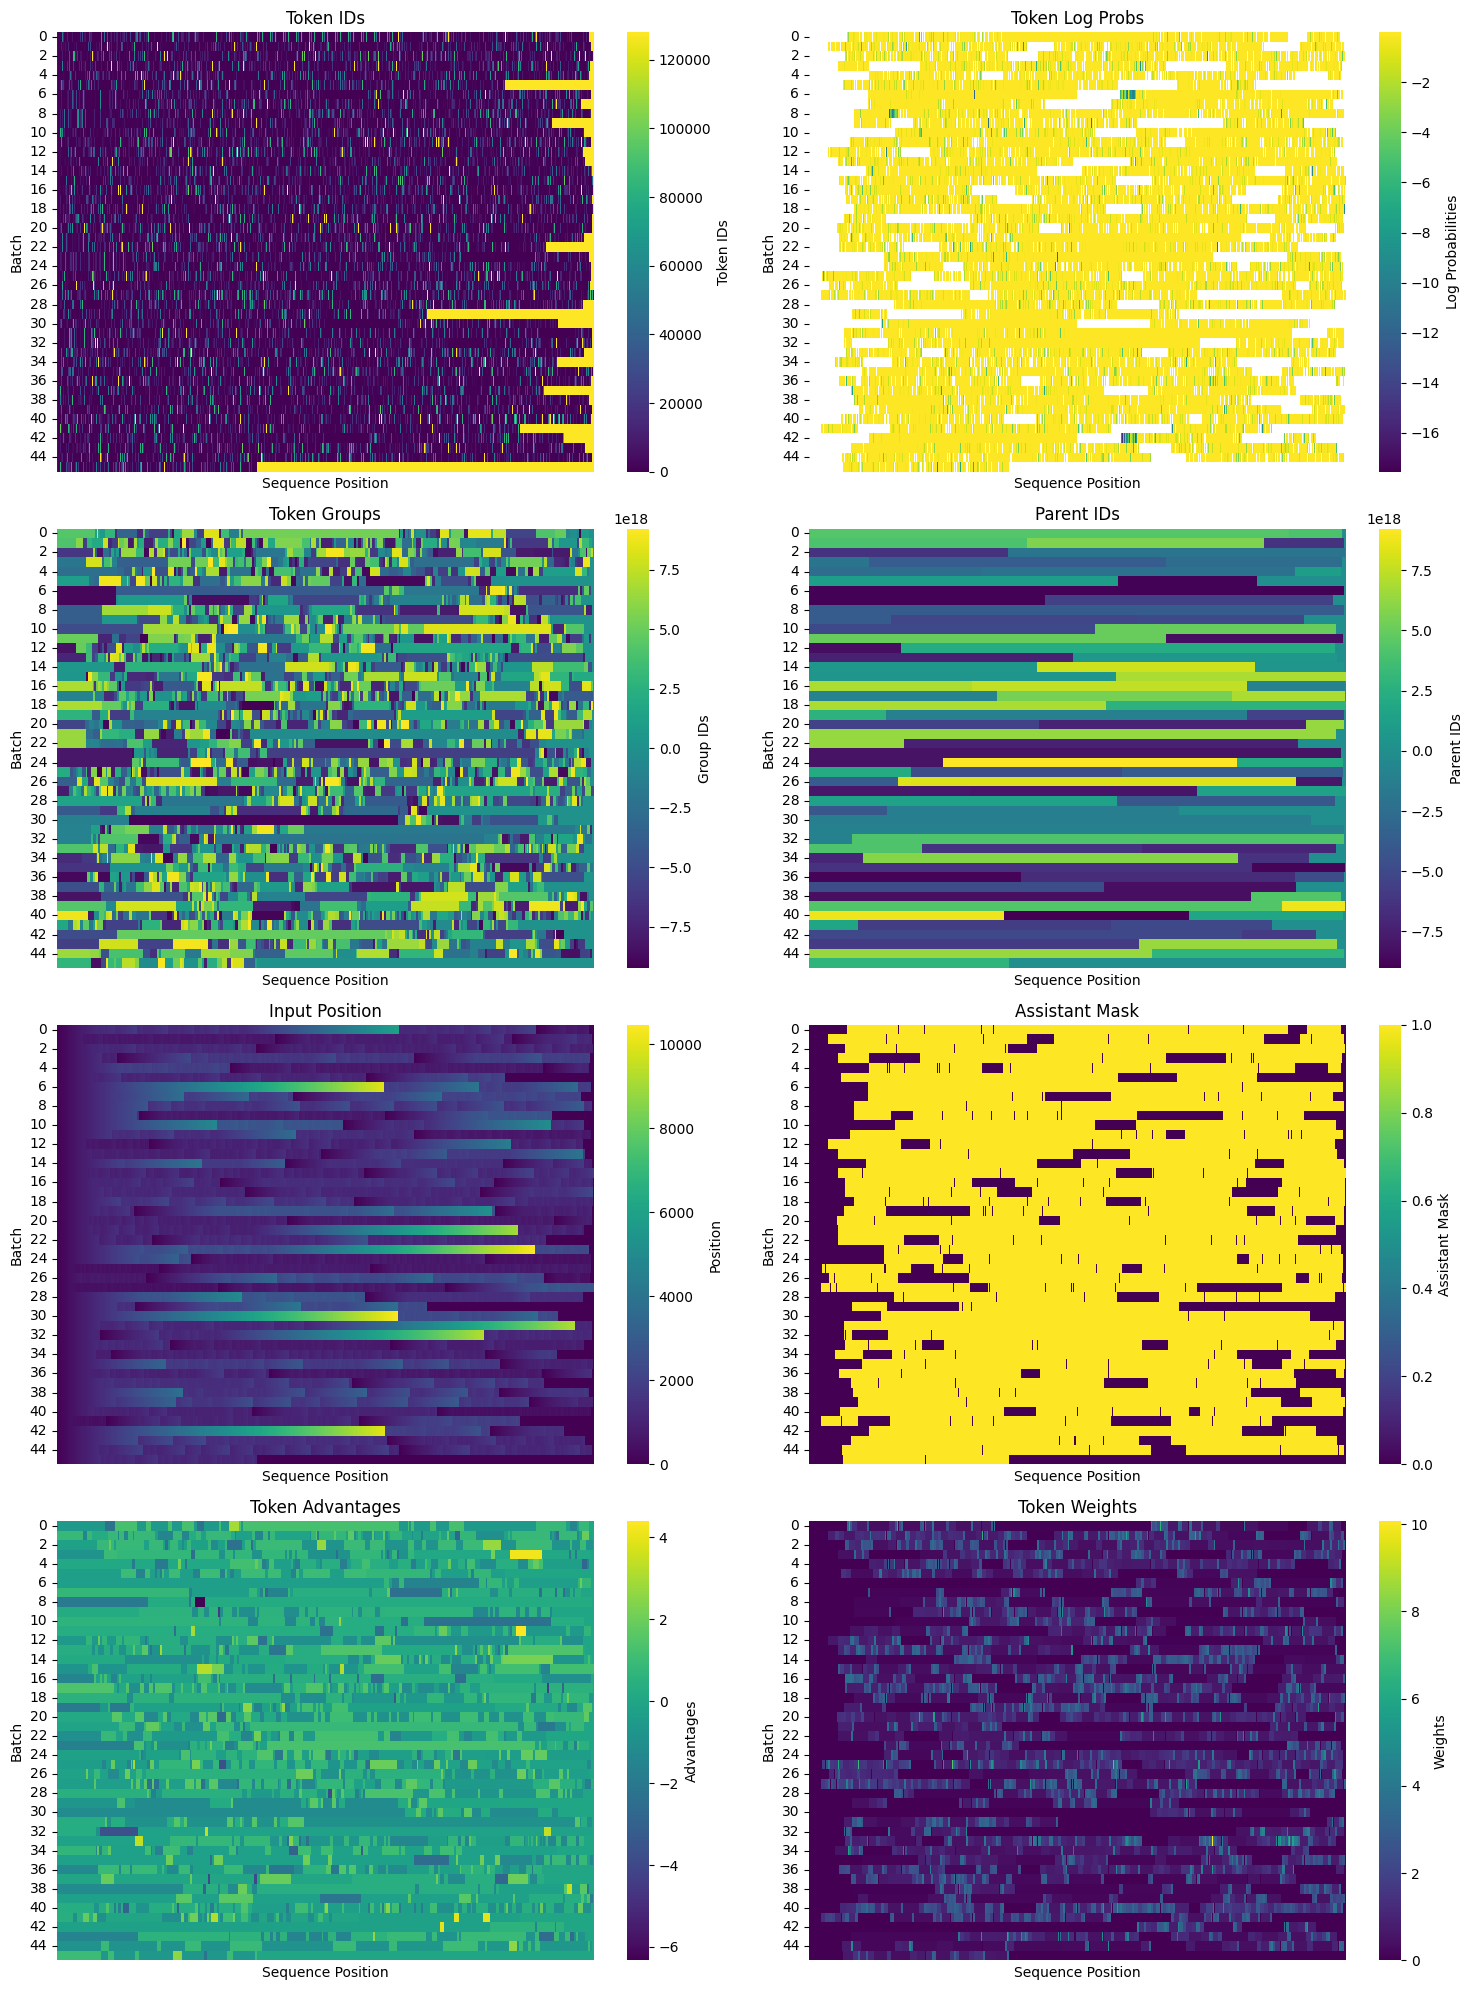

rsyncing /home/ubuntu/sky_workdir/experiments/models/025 to gs://atreides/openpipe/models/025
$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/025/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/025/0007
  checkpoint_files:
  - hf_model_0004.pt
  - hf_model_0003.pt
  - hf_model_0002.pt
  - hf_model_0001.pt
  model_type: LLAMA3
  output_dir: ./models/025
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/025/tensors
  num_sequences: 46
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tanh: false
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.training.metric

Writing logs to models/025/logs/log_1740113979.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 36.07 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|23|Loss: 0.0193: 100%|██████████| 23/23 [09:58<00:00, 25.19s/it, entropy=0.343, kl_div=nan, loss=0.0193, policy=0.0193]     INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 10.70 secs
INFO:torchtune.utils._logging:Model checkpoint of size 4.98 GB sa

Saved iteration #8 model files to ./models/025/0008
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/025/0008 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/025/0008 --port=8000 --api-key=default
INFO 02-21 05:11:03 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 05:11:04 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 05:11:04 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/025/0008', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:01<00:03,  1.27s/it]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:06<00:07,  3.60s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:09<00:03,  3.36s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:12<00:00,  3.15s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:12<00:00,  3.10s/it]



INFO 02-21 05:11:30 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-21 05:11:31 worker.py:267] Memory profiling takes 0.90 seconds
INFO 02-21 05:11:31 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-21 05:11:31 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.24GiB.
INFO 02-21 05:11:32 executor_base.py:110] # CUDA blocks: 14140, # CPU blocks: 20480
INFO 02-21 05:11:32 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.62x
INFO 02-21 05:12:20 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 49.67 seconds
INFO 02-21 05:12:21 api_server.py:756] Using supplied chat template:
INFO 02-21 05:12:21 api_server.py:756] None
INFO 02-21 05:12:21 launcher.py:21] Available routes are:
INFO 02-21 05:12:21 launcher.py:29] Route: /

INFO:     Started server process [32918]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 05:12:21 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:39340 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [05:12<00:00,  2.99s/it, completion_tokens=156, prompt_tokens=1168, reward=0.325, token_logprobs=498196]
Deleted iteration directory ./models/025/0007


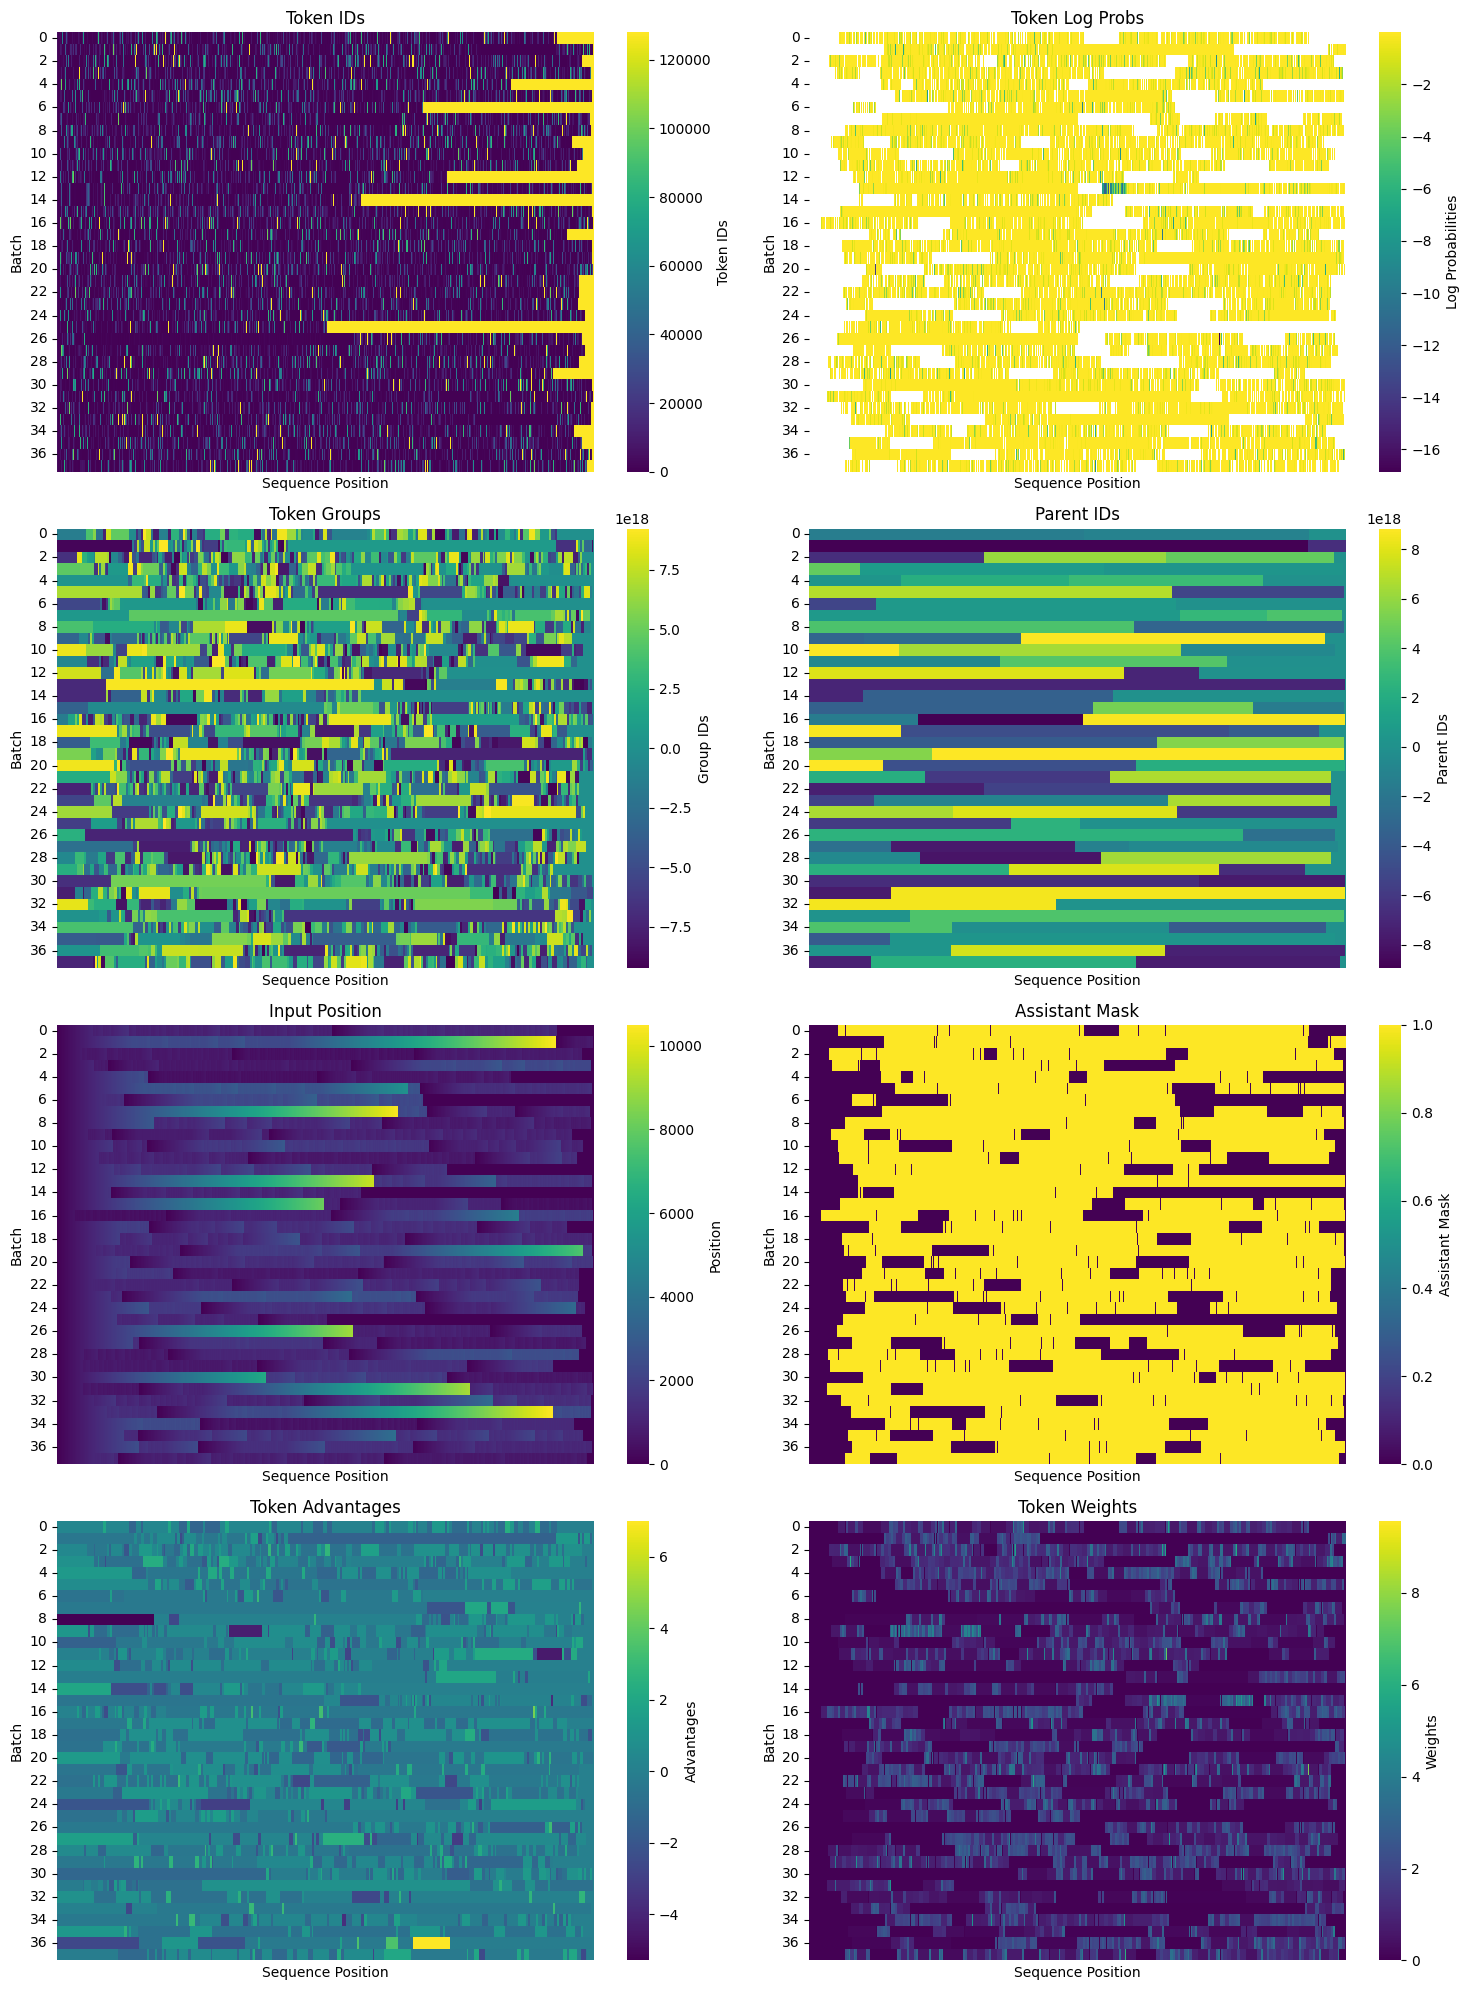

rsyncing /home/ubuntu/sky_workdir/experiments/models/025 to gs://atreides/openpipe/models/025
$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/025/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/025/0008
  checkpoint_files:
  - hf_model_0004.pt
  - hf_model_0003.pt
  - hf_model_0002.pt
  - hf_model_0001.pt
  model_type: LLAMA3
  output_dir: ./models/025
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/025/tensors
  num_sequences: 38
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tanh: false
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.training.metric

Writing logs to models/025/logs/log_1740115086.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 36.12 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|19|Loss: -0.0543: 100%|██████████| 19/19 [08:15<00:00, 24.93s/it, entropy=0.205, kl_div=nan, loss=-0.0543, policy=-0.0543]  INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 10.93 secs
INFO:torchtune.utils._logging:Model checkpoint of size 4.98 GB sa

Saved iteration #9 model files to ./models/025/0009
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/025/0009 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/025/0009 --port=8000 --api-key=default
INFO 02-21 05:27:47 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 05:27:49 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 05:27:49 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/025/0009', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:01<00:03,  1.26s/it]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:05<00:05,  2.80s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:08<00:02,  2.85s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:10<00:00,  2.84s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:10<00:00,  2.72s/it]



INFO 02-21 05:28:17 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-21 05:28:18 worker.py:267] Memory profiling takes 0.86 seconds
INFO 02-21 05:28:18 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-21 05:28:18 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.24GiB.
INFO 02-21 05:28:18 executor_base.py:110] # CUDA blocks: 14140, # CPU blocks: 20480
INFO 02-21 05:28:18 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.62x
INFO 02-21 05:29:07 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 49.84 seconds
INFO 02-21 05:29:08 api_server.py:756] Using supplied chat template:
INFO 02-21 05:29:08 api_server.py:756] None
INFO 02-21 05:29:08 launcher.py:21] Available routes are:
INFO 02-21 05:29:08 launcher.py:29] Route: /

INFO:     Started server process [37849]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 05:29:10 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:54578 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [05:06<00:00,  2.96s/it, completion_tokens=149, prompt_tokens=1252, reward=0.334, token_logprobs=475335]
Deleted iteration directory ./models/025/0005


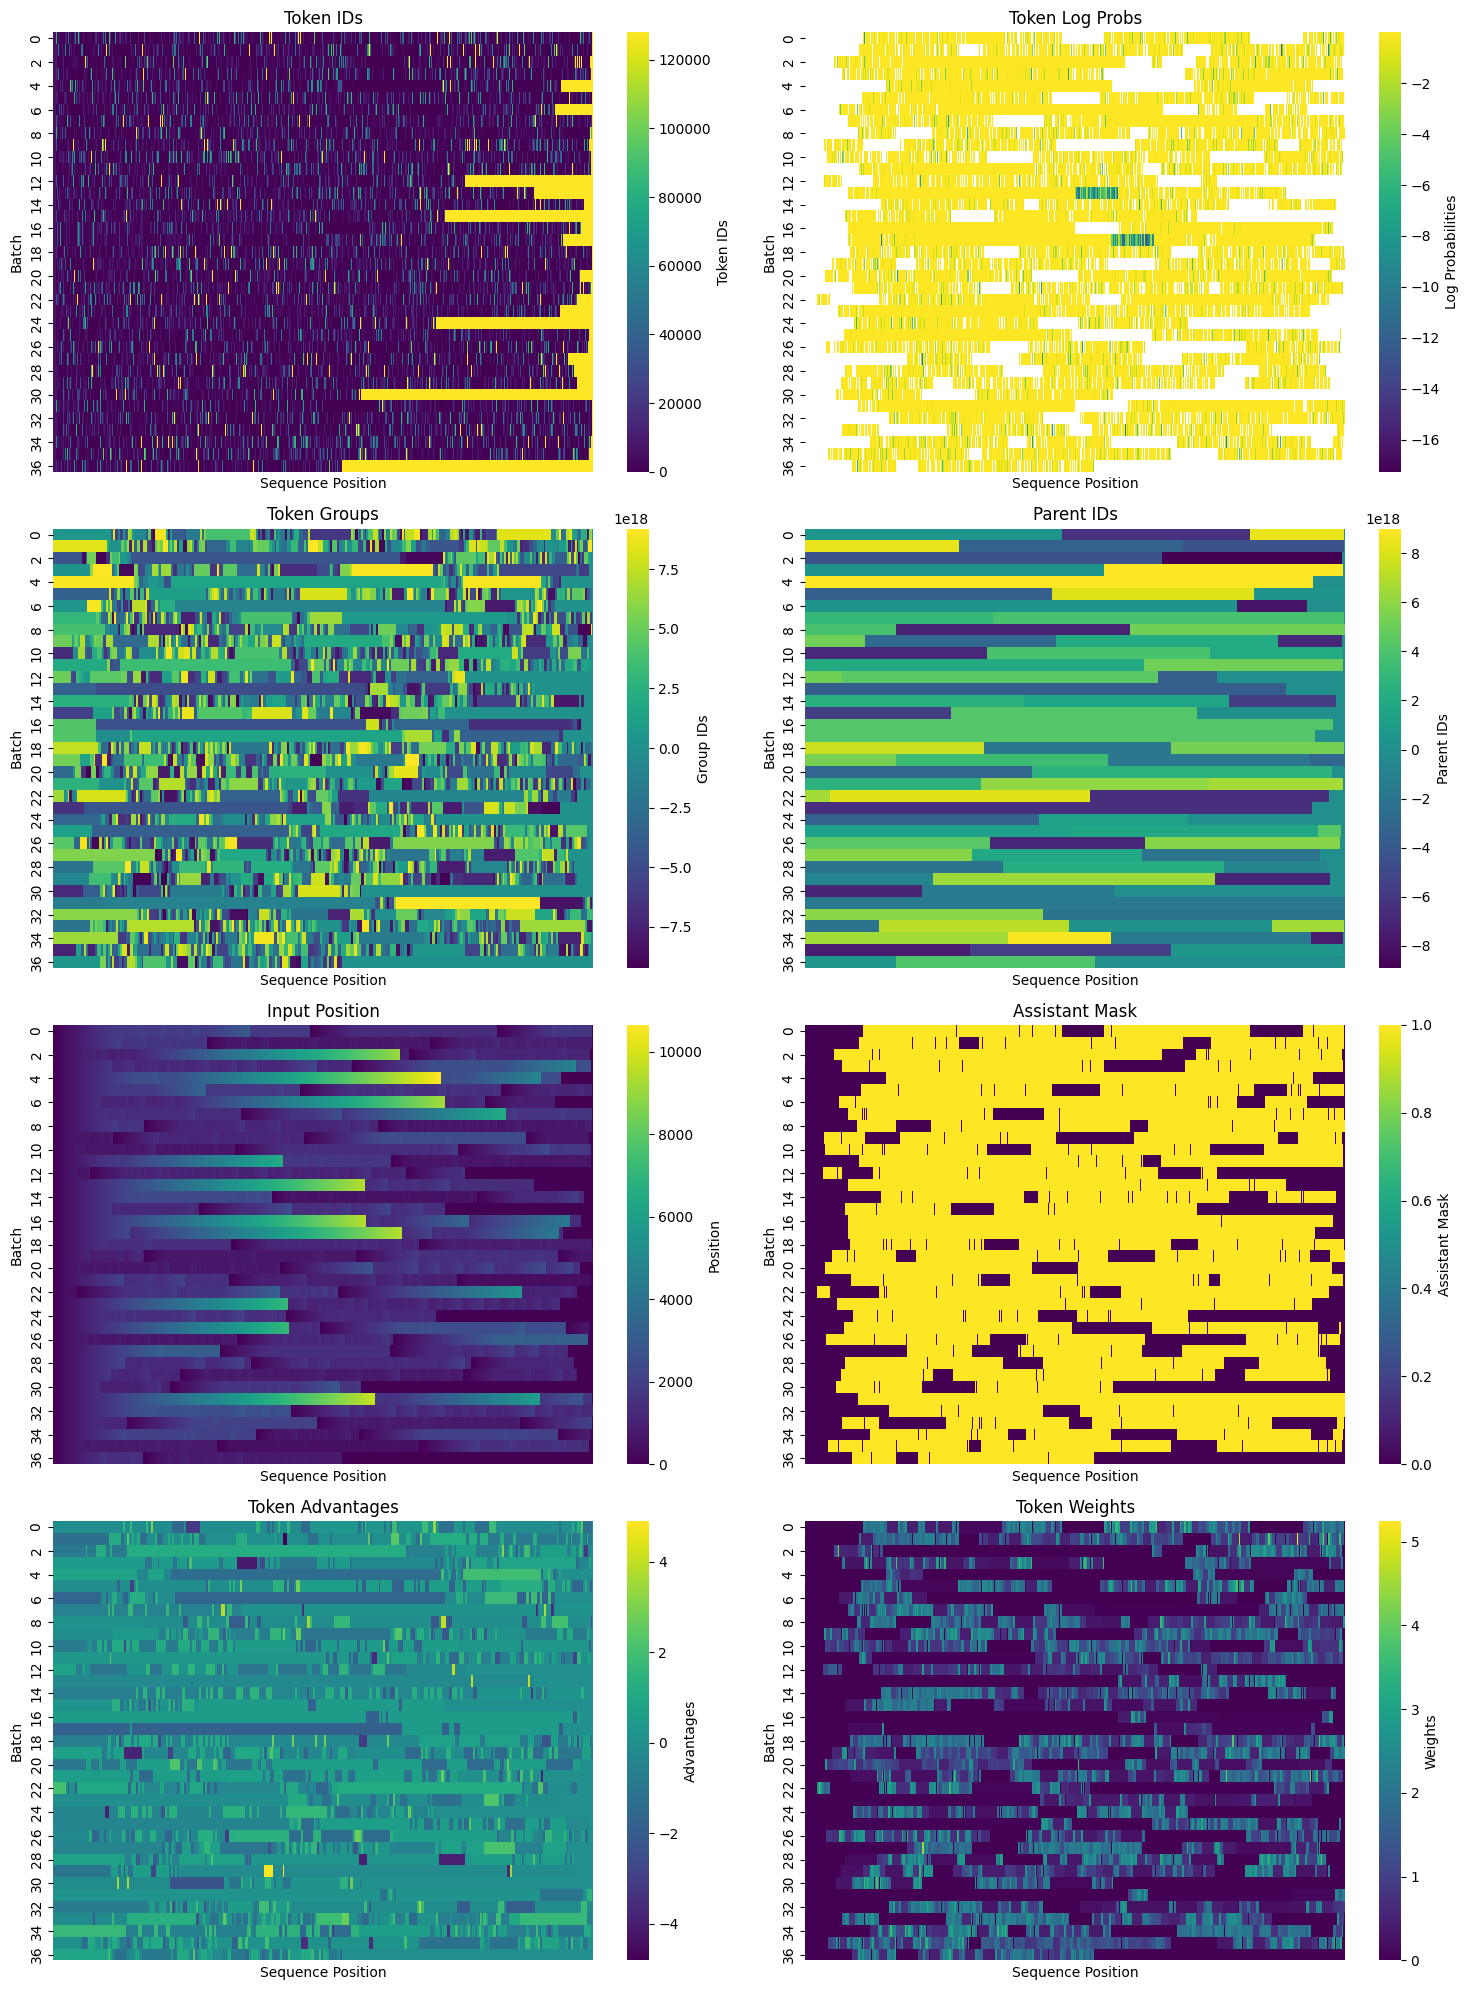

rsyncing /home/ubuntu/sky_workdir/experiments/models/025 to gs://atreides/openpipe/models/025
$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/025/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/025/0009
  checkpoint_files:
  - hf_model_0004.pt
  - hf_model_0003.pt
  - hf_model_0002.pt
  - hf_model_0001.pt
  model_type: LLAMA3
  output_dir: ./models/025
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/025/tensors
  num_sequences: 37
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tanh: false
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.training.metric

Writing logs to models/025/logs/log_1740116088.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 24.86 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|18|Loss: 0.0345: 100%|██████████| 18/18 [07:48<00:00, 25.22s/it, entropy=0.386, kl_div=nan, loss=0.0345, policy=0.0345]     INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 10.63 secs
INFO:torchtune.utils._logging:Model checkpoint of size 4.98 GB sa

Saved iteration #10 model files to ./models/025/0010
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/025/0010 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/025/0010 --port=8000 --api-key=default
INFO 02-21 05:43:50 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 05:43:51 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 05:43:51 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/025/0010', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=Non

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:01<00:03,  1.28s/it]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:06<00:07,  3.61s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:09<00:03,  3.35s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:12<00:00,  3.16s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:12<00:00,  3.10s/it]



INFO 02-21 05:44:17 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-21 05:44:18 worker.py:267] Memory profiling takes 0.91 seconds
INFO 02-21 05:44:18 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-21 05:44:18 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.24GiB.
INFO 02-21 05:44:18 executor_base.py:110] # CUDA blocks: 14140, # CPU blocks: 20480
INFO 02-21 05:44:18 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.62x
INFO 02-21 05:45:04 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 47.68 seconds
INFO 02-21 05:45:05 api_server.py:756] Using supplied chat template:
INFO 02-21 05:45:05 api_server.py:756] None
INFO 02-21 05:45:05 launcher.py:21] Available routes are:
INFO 02-21 05:45:05 launcher.py:29] Route: /

INFO:     Started server process [42630]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 05:45:07 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:46324 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [04:41<00:00,  3.43s/it, completion_tokens=116, prompt_tokens=1260, reward=0.337, token_logprobs=372454]
Deleted iteration directory ./models/025/0008


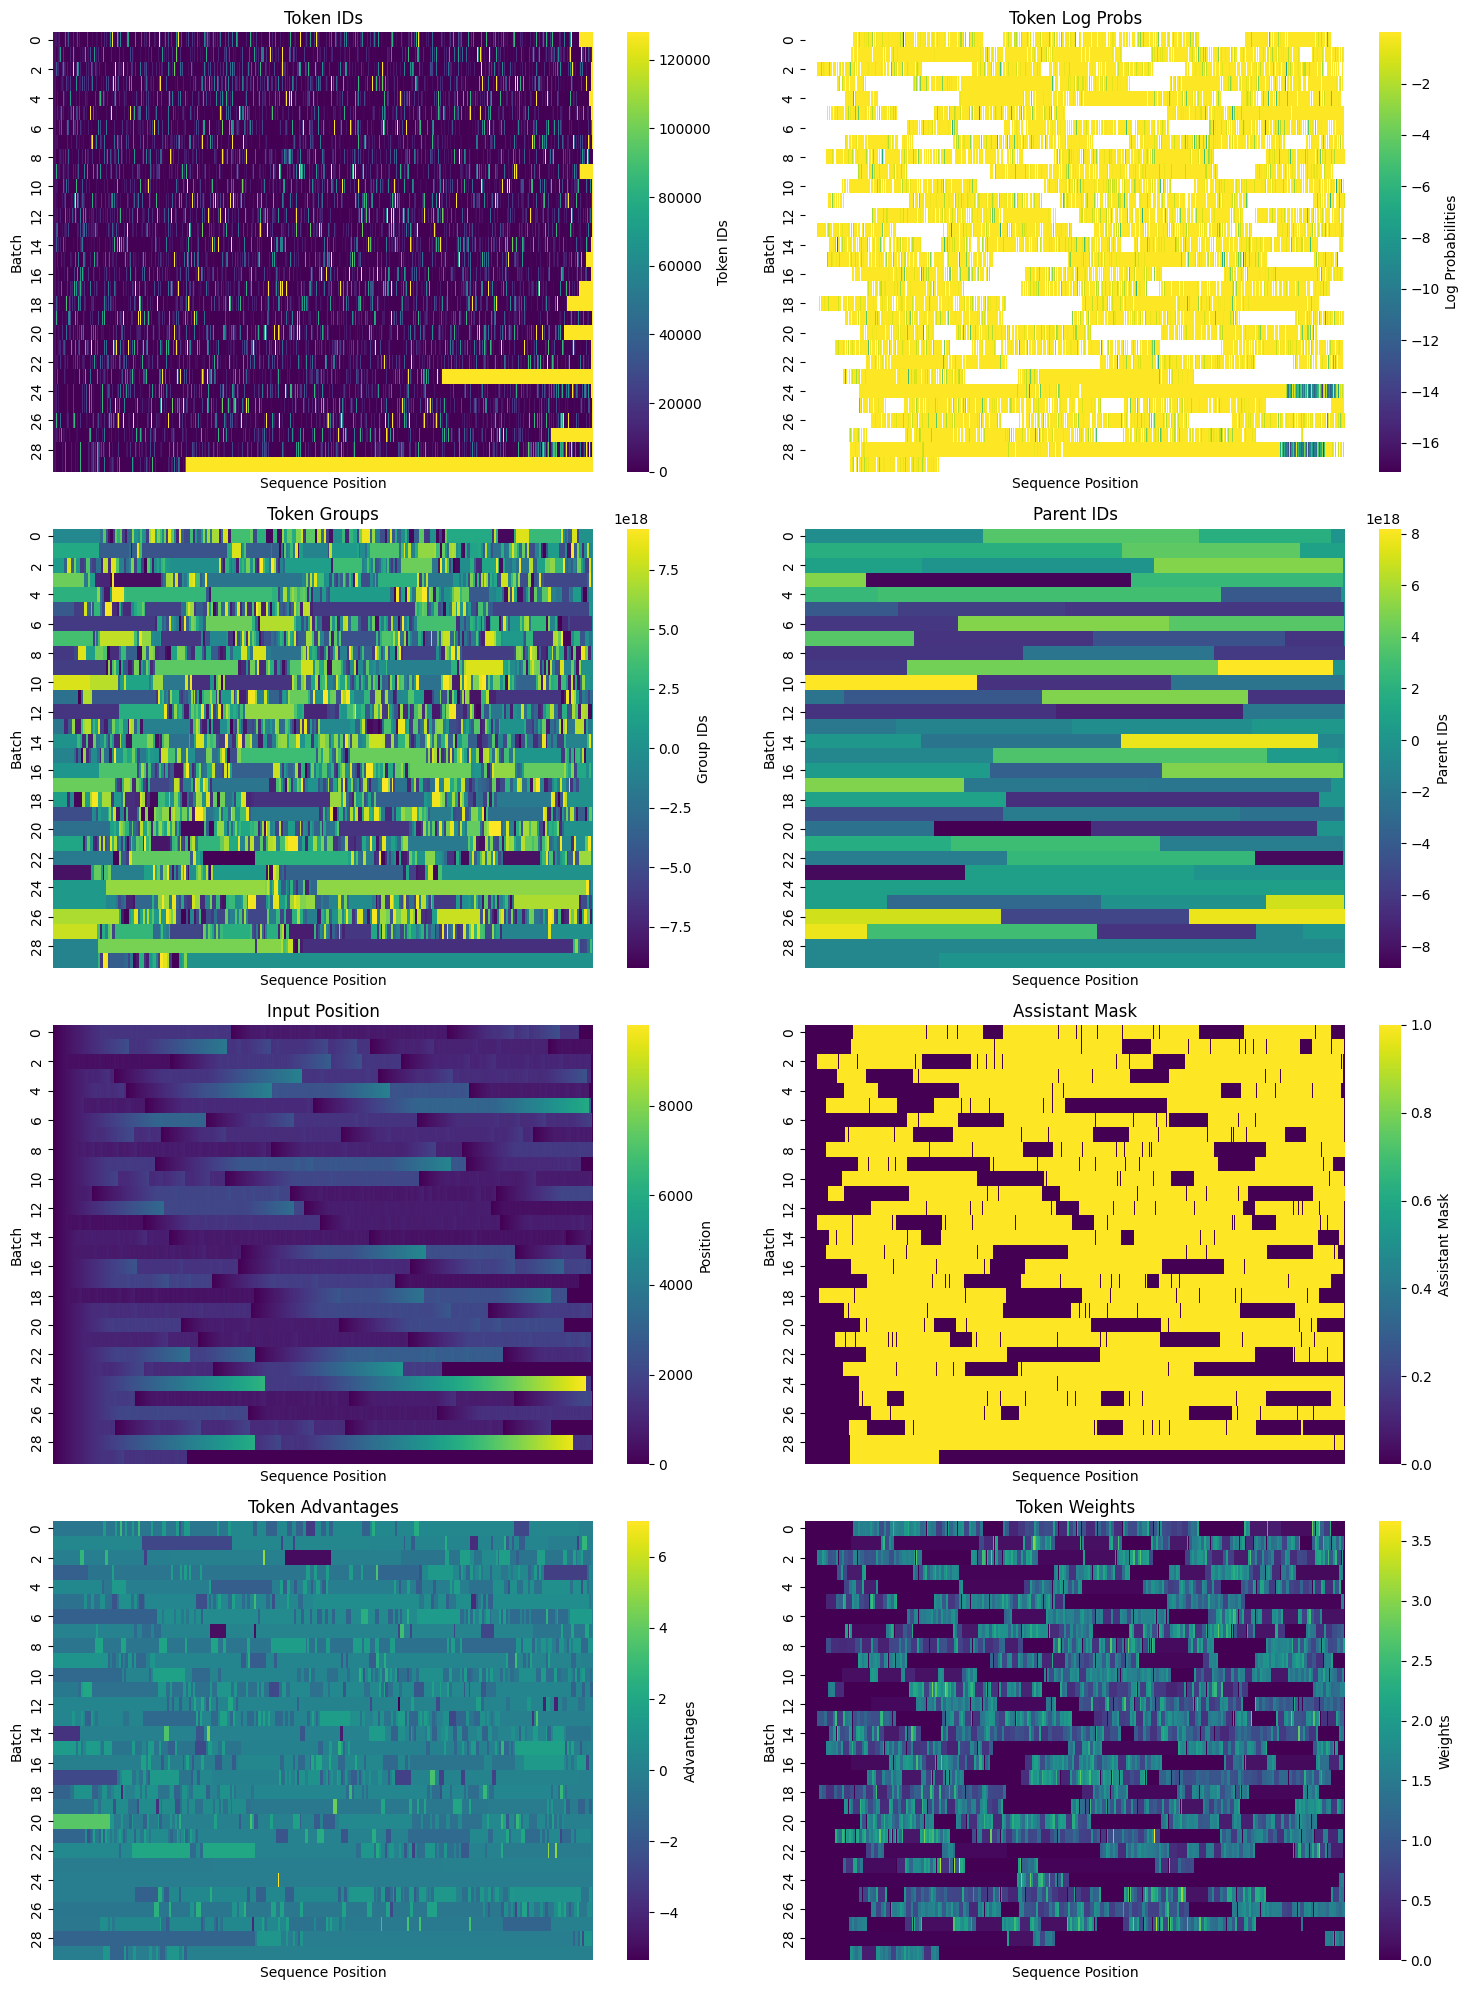

rsyncing /home/ubuntu/sky_workdir/experiments/models/025 to gs://atreides/openpipe/models/025
$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/025/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/025/0010
  checkpoint_files:
  - hf_model_0004.pt
  - hf_model_0003.pt
  - hf_model_0002.pt
  - hf_model_0001.pt
  model_type: LLAMA3
  output_dir: ./models/025
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/025/tensors
  num_sequences: 30
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tanh: false
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.training.metric

Writing logs to models/025/logs/log_1740117022.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 32.57 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|15|Loss: 0.0067: 100%|██████████| 15/15 [06:35<00:00, 25.30s/it, entropy=0.137, kl_div=nan, loss=0.00673, policy=0.00673] INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 12.35 secs
INFO:torchtune.utils._logging:Model checkpoint of size 4.98 GB save

Saved iteration #11 model files to ./models/025/0011
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/025/0011 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/025/0011 --port=8000 --api-key=default
INFO 02-21 05:58:21 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 05:58:22 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 05:58:22 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/025/0011', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=Non

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:01<00:03,  1.23s/it]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:04<00:05,  2.50s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:07<00:02,  2.70s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:10<00:00,  2.75s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:10<00:00,  2.60s/it]



INFO 02-21 05:58:46 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-21 05:58:47 worker.py:267] Memory profiling takes 0.88 seconds
INFO 02-21 05:58:47 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-21 05:58:47 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.24GiB.
INFO 02-21 05:58:47 executor_base.py:110] # CUDA blocks: 14140, # CPU blocks: 20480
INFO 02-21 05:58:47 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.62x
INFO 02-21 05:59:40 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 53.61 seconds
INFO 02-21 05:59:41 api_server.py:756] Using supplied chat template:
INFO 02-21 05:59:41 api_server.py:756] None
INFO 02-21 05:59:41 launcher.py:21] Available routes are:
INFO 02-21 05:59:41 launcher.py:29] Route: /

INFO:     Started server process [47149]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 05:59:41 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:54662 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [04:47<00:00,  2.13s/it, completion_tokens=113, prompt_tokens=1275, reward=0.359, token_logprobs=361990]
Deleted iteration directory ./models/025/0010


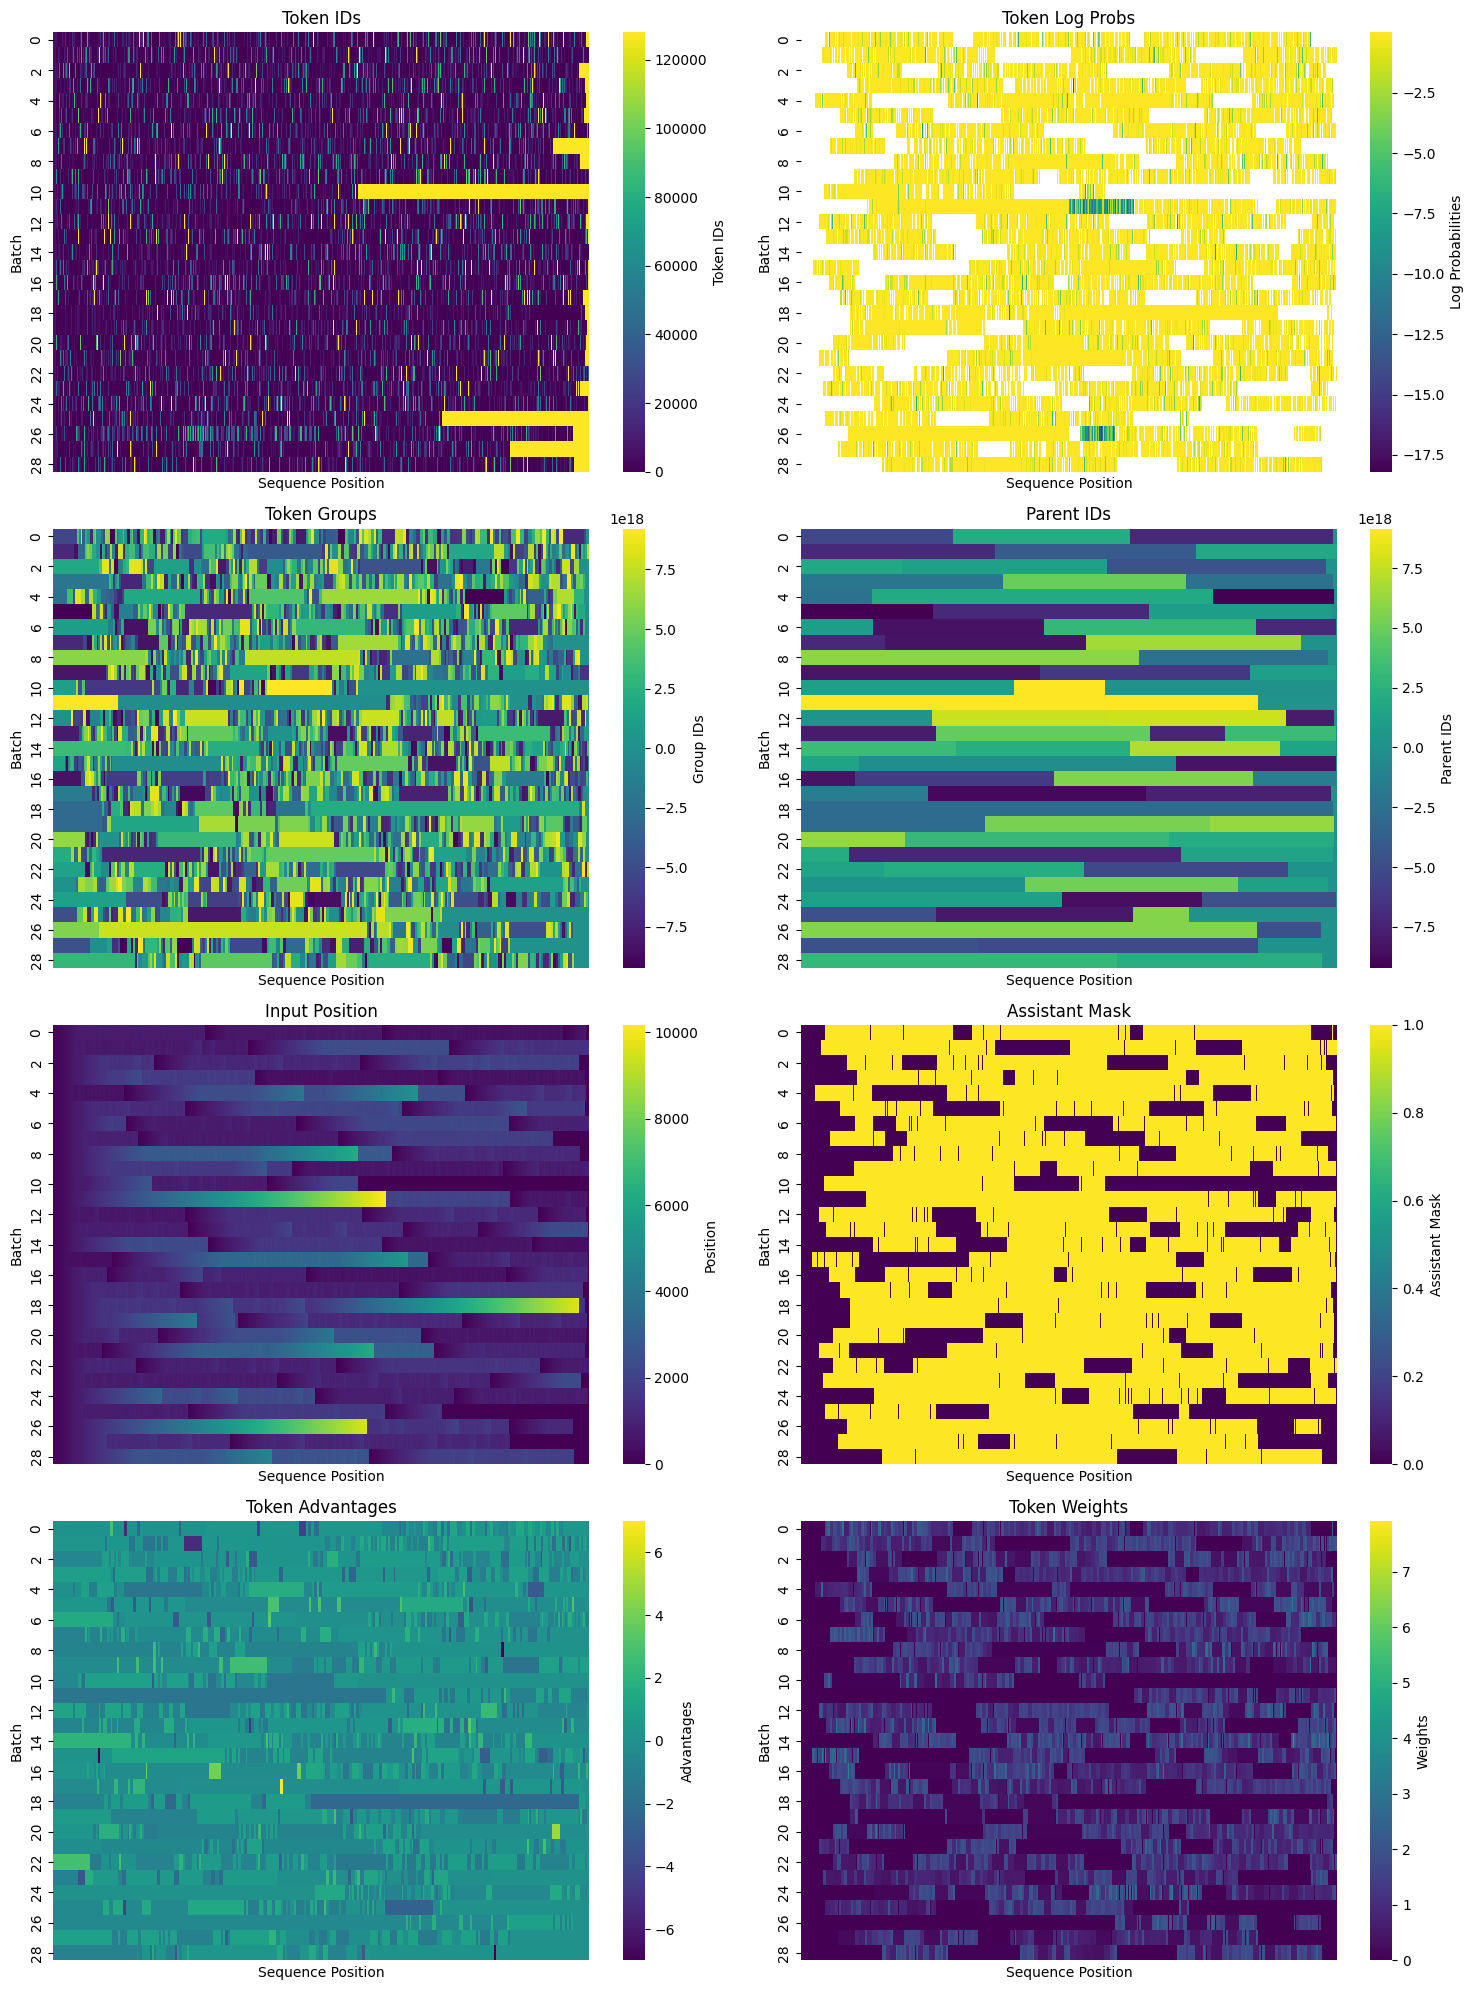

rsyncing /home/ubuntu/sky_workdir/experiments/models/025 to gs://atreides/openpipe/models/025
$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/025/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/025/0011
  checkpoint_files:
  - hf_model_0004.pt
  - hf_model_0003.pt
  - hf_model_0002.pt
  - hf_model_0001.pt
  model_type: LLAMA3
  output_dir: ./models/025
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/025/tensors
  num_sequences: 29
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tanh: false
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.training.metric

Writing logs to models/025/logs/log_1740117902.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 38.50 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|14|Loss: 0.0070: 100%|██████████| 14/14 [06:11<00:00, 25.11s/it, entropy=0.358, kl_div=nan, loss=0.00696, policy=0.00696]   INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 10.60 secs
INFO:torchtune.utils._logging:Model checkpoint of size 4.98 GB sa

Saved iteration #12 model files to ./models/025/0012
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/025/0012 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/025/0012 --port=8000 --api-key=default
INFO 02-21 06:12:37 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 06:12:38 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 06:12:38 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/025/0012', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=Non

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:01<00:03,  1.27s/it]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:06<00:06,  3.31s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:08<00:03,  3.14s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:11<00:00,  3.03s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:11<00:00,  2.95s/it]



INFO 02-21 06:13:07 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-21 06:13:08 worker.py:267] Memory profiling takes 0.89 seconds
INFO 02-21 06:13:08 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-21 06:13:08 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.24GiB.
INFO 02-21 06:13:08 executor_base.py:110] # CUDA blocks: 14140, # CPU blocks: 20480
INFO 02-21 06:13:08 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.62x
INFO 02-21 06:13:57 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 50.18 seconds
INFO 02-21 06:13:59 api_server.py:756] Using supplied chat template:
INFO 02-21 06:13:59 api_server.py:756] None
INFO 02-21 06:13:59 launcher.py:21] Available routes are:
INFO 02-21 06:13:59 launcher.py:29] Route: /

INFO:     Started server process [49685]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 06:13:59 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:53954 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [04:23<00:00,  1.52s/it, completion_tokens=110, prompt_tokens=1282, reward=0.359, token_logprobs=351015]
Deleted iteration directory ./models/025/0011


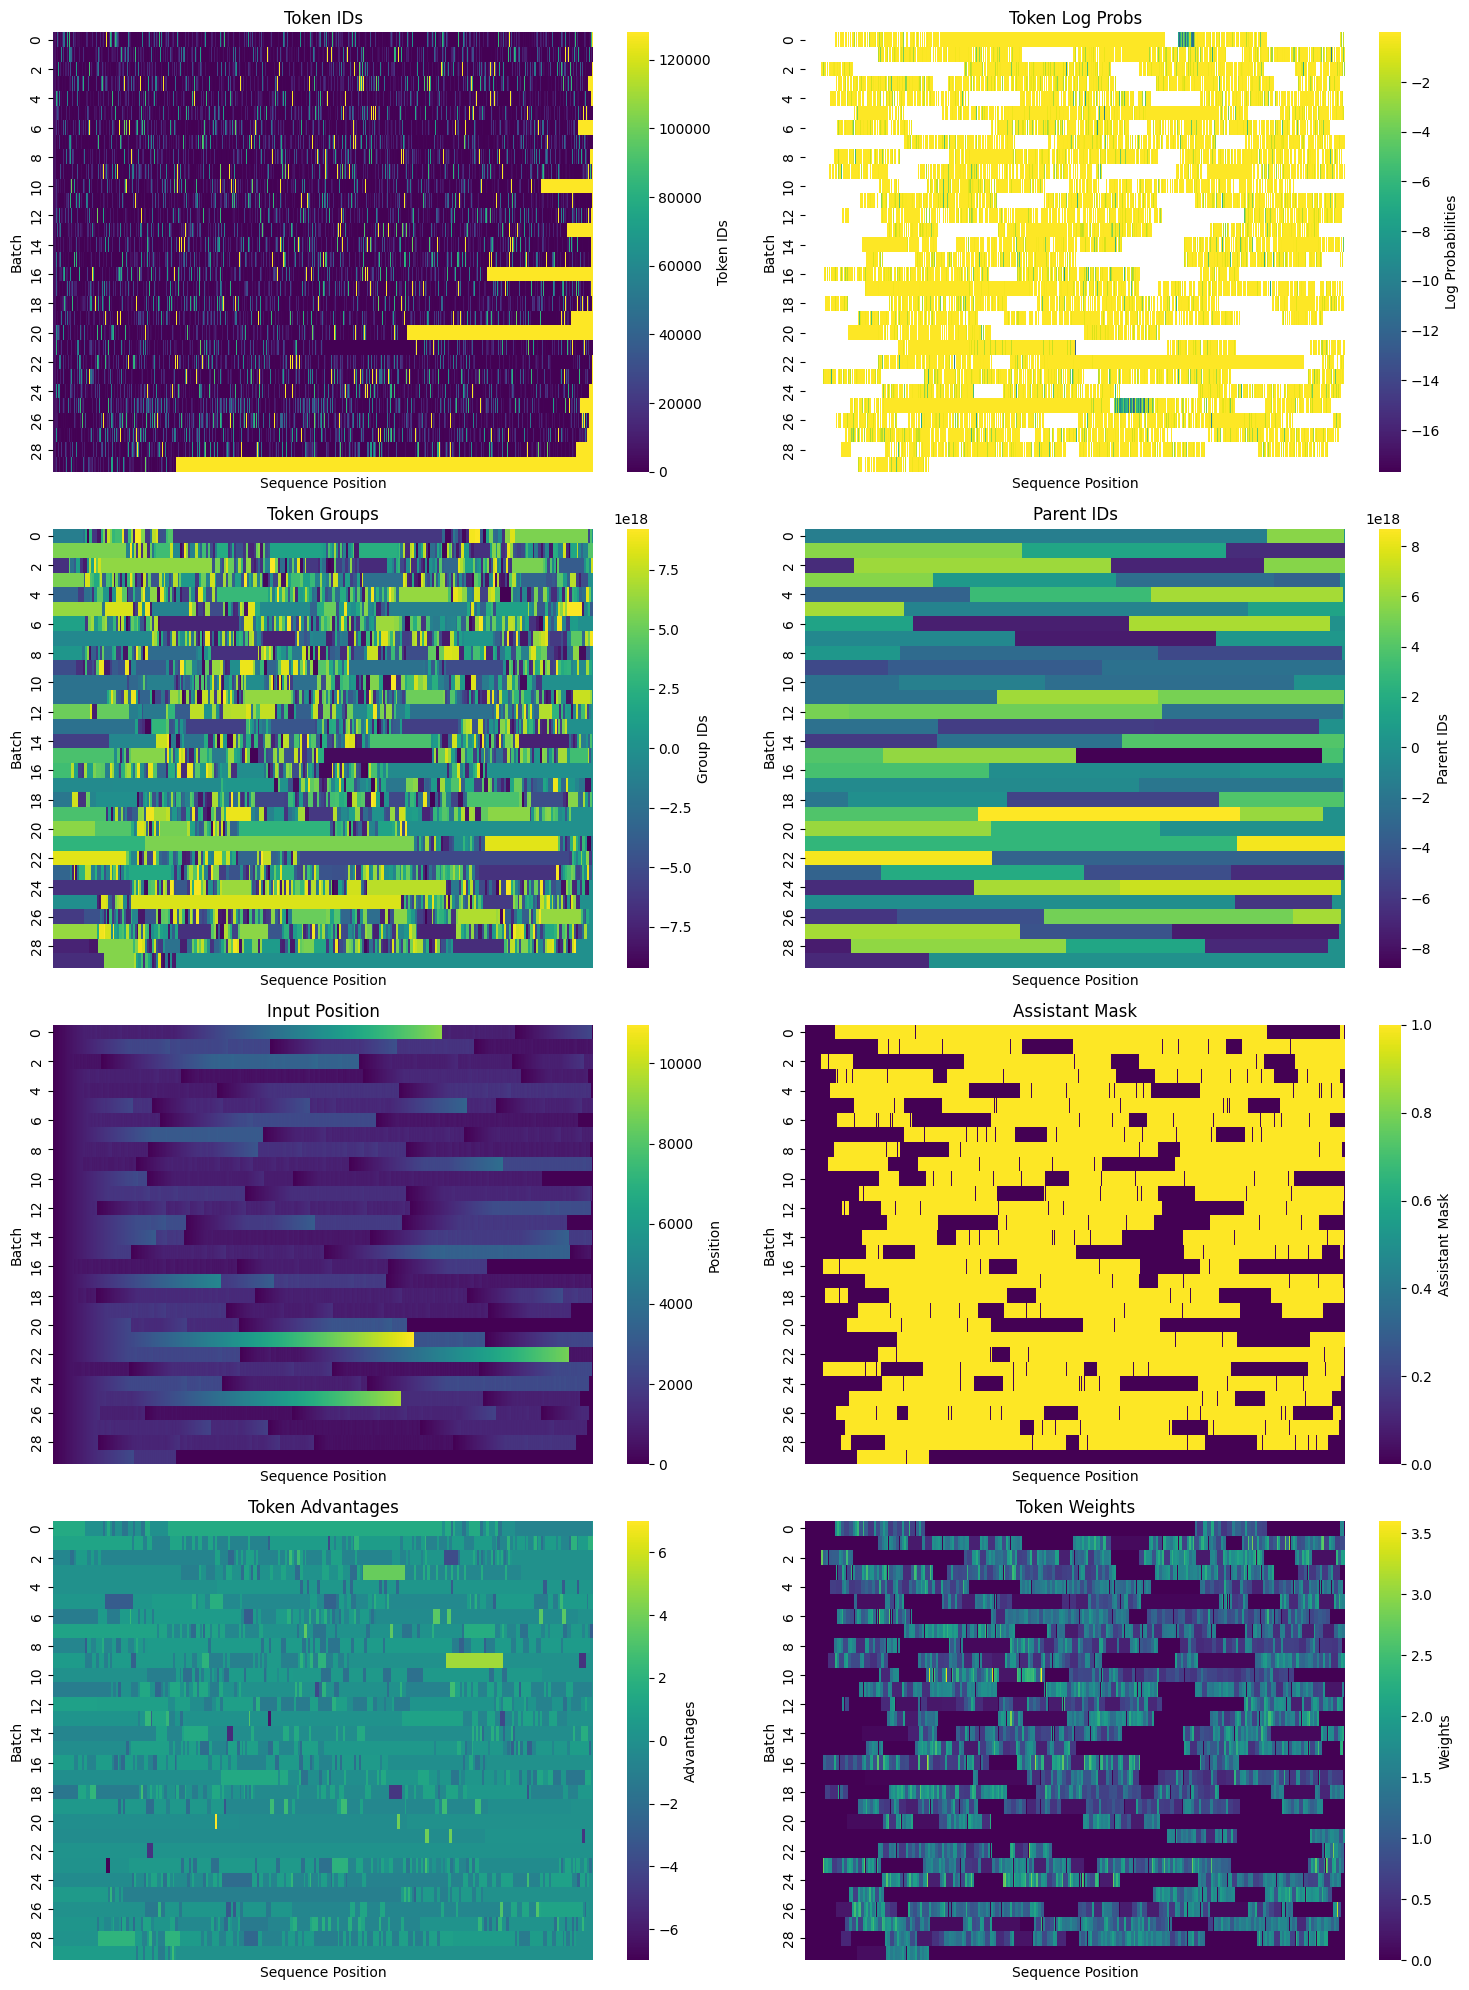

rsyncing /home/ubuntu/sky_workdir/experiments/models/025 to gs://atreides/openpipe/models/025
$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/025/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/025/0012
  checkpoint_files:
  - hf_model_0004.pt
  - hf_model_0003.pt
  - hf_model_0002.pt
  - hf_model_0001.pt
  model_type: LLAMA3
  output_dir: ./models/025
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/025/tensors
  num_sequences: 30
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tanh: false
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.training.metric

Writing logs to models/025/logs/log_1740118735.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 36.26 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|15|Loss: 0.0390: 100%|██████████| 15/15 [06:35<00:00, 25.05s/it, entropy=0.412, kl_div=nan, loss=0.039, policy=0.039]       INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 10.84 secs
INFO:torchtune.utils._logging:Model checkpoint of size 4.98 GB sa

Saved iteration #13 model files to ./models/025/0013
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/025/0013 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/025/0013 --port=8000 --api-key=default
INFO 02-21 06:26:56 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 06:26:57 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 06:26:57 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/025/0013', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=Non

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:01<00:03,  1.27s/it]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:05<00:05,  2.99s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:08<00:02,  2.98s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:11<00:00,  2.93s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:11<00:00,  2.82s/it]



INFO 02-21 06:27:21 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-21 06:27:22 worker.py:267] Memory profiling takes 0.84 seconds
INFO 02-21 06:27:22 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-21 06:27:22 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.24GiB.
INFO 02-21 06:27:23 executor_base.py:110] # CUDA blocks: 14140, # CPU blocks: 20480
INFO 02-21 06:27:23 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.62x
INFO 02-21 06:28:19 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 57.74 seconds
INFO 02-21 06:28:20 api_server.py:756] Using supplied chat template:
INFO 02-21 06:28:20 api_server.py:756] None
INFO 02-21 06:28:20 launcher.py:21] Available routes are:
INFO 02-21 06:28:20 launcher.py:29] Route: /

INFO:     Started server process [51753]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 06:28:27 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO 02-21 06:28:27 metrics.py:455] Avg prompt throughput: 1.5 tokens/s, Avg generation throughput: 0.2 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 02-21 06:28:27 metrics.py:471] Prefix cache hit rate: GPU: 0.00%, CPU: 0.00%
INFO:     127.0.0.1:52758 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [04:22<00:00,  1.24it/s, completion_tokens=100, prompt_tokens=1131, reward=0.375, token_logprobs=319186]
Deleted iteration directory ./models/025/0012


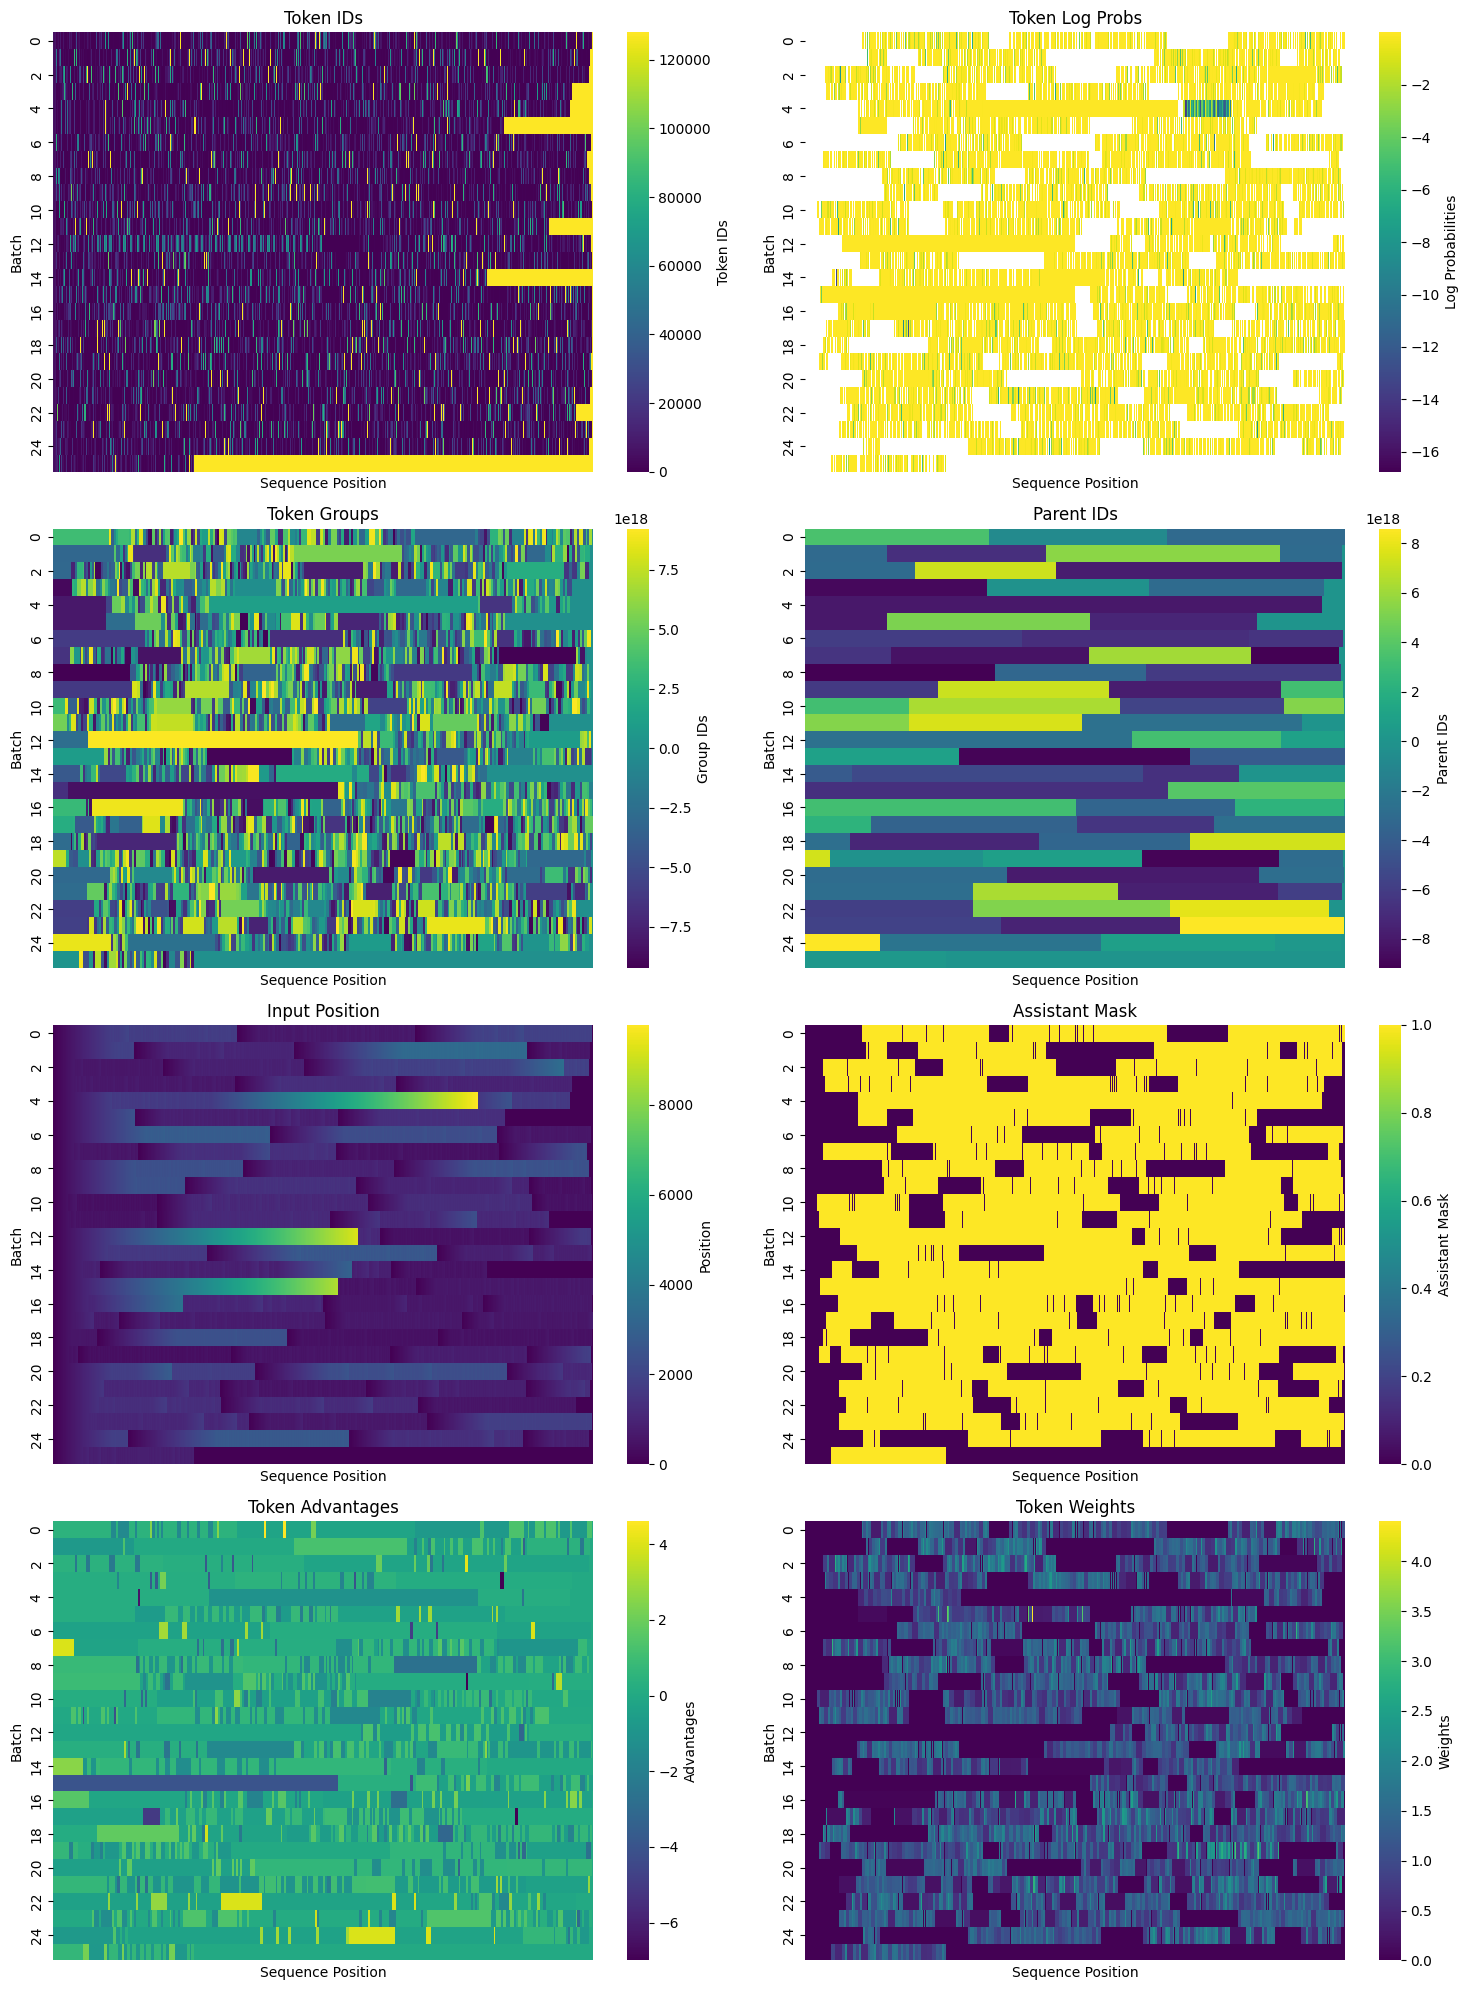

rsyncing /home/ubuntu/sky_workdir/experiments/models/025 to gs://atreides/openpipe/models/025
$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/025/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/025/0013
  checkpoint_files:
  - hf_model_0004.pt
  - hf_model_0003.pt
  - hf_model_0002.pt
  - hf_model_0001.pt
  model_type: LLAMA3
  output_dir: ./models/025
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/025/tensors
  num_sequences: 26
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tanh: false
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.training.metric

Writing logs to models/025/logs/log_1740119602.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...


In [ ]:
model_name = get_last_iteration_dir(output_dir) or model.base_model
for i in range(get_iteration(output_dir), num_iterations):
    vllm = await start_vllm(
        model_name,
        max_concurrent_requests=1024,
        env={"VLLM_ALLOW_LONG_MAX_MODEL_LEN": "1"},
        named_arguments=dict(
            block_size=32,
            disable_log_requests=True,
            enable_prefix_caching=True,
            enforce_eager=True,
            gpu_memory_utilization=0.95,
            max_model_len=16384,
            max_num_seqs=1024,
            max_num_batched_tokens=16384,
            num_scheduler_steps=8,
            preemption_mode="swap",
            return_tokens_as_token_ids=True,
            swap_space=80,
            tensor_parallel_size=torch.cuda.device_count(),
        ),
        timeout=180 + 15 * torch.cuda.device_count(),
        verbosity=verbosity,
    )
    semaphore = asyncio.Semaphore(
        int(1.33 * vllm.max_concurrent_tokens / expected_tokens)
    )
    offset = i * stride
    val_results, train_results = await asyncio.gather(
        get_task_results(
            tasks=val_tasks,
            client=vllm.client,
            model=vllm.model,
            cache=False,
            log_results=8,
            params=ChatCompletionParams(
                stream_options={
                    "include_usage": True,
                },
                max_completion_tokens=8192,
            ),
            pbar_desc="val",
            semaphore=semaphore,
        ),
        get_task_results(
            tasks=list(islice(cycle(train_tasks), offset, offset + tasks_per_iter)),
            client=vllm.client,
            model=vllm.model,
            cache=False,
            log_results=False,
            n=samples_per_task,
            params=ChatCompletionParams(
                stream_options={
                    "include_usage": True,
                },
                max_completion_tokens=8192,
            ),
            pbar_desc="train",
            semaphore=semaphore,
            transform=TaskResultTokenizer(tokenizer),
        ),
    )
    vllm.process.terminate()
    kill_vllm_workers()
    val_stats = val_results.stats
    assert val_stats.grades > 0
    assert val_stats.usages > 0
    wandb_data = {
        "iteration": i,
        "exceptions": val_stats.exceptions + train_results.stats.exceptions,
        "reward": val_stats.total_reward / val_stats.grades,
        "tokens": round(val_stats.completion_tokens / val_stats.usages),
    }
    try:
        wandb_data.update(
            pl.DataFrame(last_tune_log(output_dir)).drop("step").mean().to_dicts()[0]
        )
    except Exception:
        pass
    wandb.log(wandb_data)
    expected_tokens = wandb_data["tokens"]
    try:
        best_iteration = (
            wandb.Api()
            .run(f"{run.entity}/{run.project}/{run.id}")
            .history()
            .sort_values(by="reward")["iteration"]
            .iloc[-1]
        )
        clear_iteration_dirs(output_dir, [best_iteration, i])
    except Exception:
        pass
    # see ./logs/rsync.log for output
    asyncio.create_task(rsync_dir(sync_dir, "gs://atreides/openpipe/"))
    tokenized_results = [
        result
        for results in train_results
        for result in results
        if result.advantage != 0
    ]
    packed_tensors = packed_tensors_from_tokenized_results(
        tokenized_results,
        seq_len=seq_len,
        pad_token_id=tokenizer.pad_token_id,  # type: ignore
    )
    if verbosity == 2:
        plot_packed_tensors(packed_tensors)
    else:
        print(f"Packed tensors into {packed_tensors["tokens"].size()} shape")
    optimizer_config = ComponentConfig(
        model.tune_optimizer,
        lr=lr,
        betas=betas,
        weight_decay=weight_decay,
    )
    if model.tune_optimizer == "torch.optim.AdamW":
        optimizer_config.fused = True
    model_name = await tune(
        base_model=model.base_model,
        output_dir=output_dir, 
        packed_tensors=packed_tensors,
        model=model.tune_model,
        model_type=model.tune_model_type,
        config=TuneRecipeConfig(
            optimizer=optimizer_config,
            loss=ComponentConfig(
                GRPO,
                clip_epsilon=clip_epsilon,
                entropy_coef=entropy_coef,
                kl_coef=kl_coef,
                tanh=tanh,
            ),
            shuffle=True,
            batch_size=model.tune_max_batch_tokens // seq_len,
            fsdp_cpu_offload=model.tune_fsdp_cpu_offload,
            enable_activation_checkpointing=True,
            enable_activation_offloading=True,
            custom_sharded_layers=["tok_embeddings", "output"],
            num_output_chunks=2,
        ),
        verbosity=verbosity,
    )
wandb.finish()